In [1]:
from config_path import add_to_sys_path
add_to_sys_path()  # Call the function to add path

import numpy as np
from sympy.physics.wigner import wigner_3j,wigner_6j
import sympy as sy
from numpy import linalg as LA
from IPython.display import Latex,display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_palette('terrain')
from molecular_structure import MoleculeLevels
np.set_printoptions(precision=5, suppress=True)
import time
from matplotlib.colors import TwoSlopeNorm

In [2]:
import json
import ujson as uj

def get_json_data(file_path,numpy=False,ujson=True):
    if '.json' not in file_path:
        file_path+='.json'
    with open(file_path, 'r') as f:
        if ujson:
            data = uj.load(f)
        else:
            data = json.load(f)
    if numpy:
        data = np.array(data)
    return data

def save_json_data(data,file_path,ujson=True):
    if type(data) is np.ndarray:
        data_save = data.tolist()
    else:
        data_save=data
    if '.json' not in file_path:
        file_path+='.json'
    with open(file_path,'w') as f:
        if ujson:
            uj.dump(data_save,f)
        else:
            json.dump(data_save,f)
    print('Data saved to', file_path)

In [151]:
state_dict = {}
eval_dict = {}
PTV_dict = {}


Bz = np.linspace(0,0.5,1000)
Ez = np.linspace(59,63,1000)

#2022 03 10 data
# Bz = np.linspace(0,20,2000) 
# Ez = np.linspace(0,500,2000)

mesh = np.array(np.meshgrid(Ez,Bz,indexing='ij'))

In [152]:
read = False
for M in range(-1,2,1):
    M_state = MoleculeLevels.initialize_state('CaOH','40','X010',[1],M_values = 'custom',I=[0,1/2],S=1/2,round=8,M_range=[M])
    state_dict[M] = M_state
    print(M)
    if read:
        eval_dict[M] = get_json_data('X010_CaOH_N1_M{}_EB_grid_evals_20220310'.format(M),numpy=True)
        PTV_dict[M] = get_json_data('X010_CaOH_N1_M{}_EB_grid_PTV_20220310'.format(M),numpy=True)
    else:    
        t0 = time.perf_counter()
        Bslices = M_state.EB_grid(Ez,Bz,PTV=True,E_or_B_first='B',output=True,EDM_or_MQM='EDM')
        t1 = time.perf_counter()
        elapsed = t1 - t0
        print(elapsed, 'sec\n')
        eval_dict[M] = Bslices[0]
        PTV_dict[M] = Bslices[1]

-1
28.070484100000613 sec

0
31.88550750000013 sec

1
29.078299299999344 sec



In [153]:
E_thresh = 0.1
PTV_thresh = 0.1
geff_thresh = 0.01
Ez_idx_match = []
Bz_idx_match = []
eigenstate_match = []
M_match = []
evals_match = []
geff_match = []
PTV_match = []
M_list = list(eval_dict.keys())
for Midx in range(len(M_list)):
    Mi = M_list[Midx]
    for Mjdx in range(Midx,len(M_list)):
        Mj = M_list[Mjdx]
        if abs(Mi-Mj)>2:
            continue
        else:
            evals_Mi = eval_dict[Mi]
            evals_Mj = eval_dict[Mj]
            PTV_Mi = PTV_dict[Mi]
            PTV_Mj = PTV_dict[Mj]
            for i in range(len(evals_Mi)):
                for j in range(i,len(evals_Mj)):
                    if i==j and Mi==Mj:
                        continue
                    deltaE_ij = evals_Mi[i]-evals_Mj[j]
                    E_bool_match = (abs(deltaE_ij)<E_thresh)
                    if E_bool_match.any():
                        geff_i = np.gradient(evals_Mi[i])[1]/(Bz[1]-Bz[0])
                        geff_j = np.gradient(evals_Mj[j])[1]/(Bz[1]-Bz[0])
                        deltag_ij = geff_i - geff_j
                        g_bool_match = np.logical_and(abs(deltag_ij)<geff_thresh, E_bool_match)
                        if g_bool_match.any():
                            PTV_i = PTV_Mi[i]
                            PTV_j = PTV_Mj[j]
                            deltaPTV_ij = PTV_i - PTV_j
                            PTV_bool_match = np.logical_and(abs(deltaPTV_ij)>PTV_thresh, g_bool_match)
                            if PTV_bool_match.any():
                                #Found a match!
                                idx_match = PTV_bool_match.nonzero()
                                evals_match.append(deltaE_ij)
                                PTV_match.append(deltaPTV_ij)
                                geff_match.append(deltag_ij)
                                print('Found a match!')
                                print('i = {}, Mi = {}'.format(i,Mi))
                                print('j = {}, Mj = {}'.format(j,Mj))
                                print('Ez vals = {}'.format(np.unique(Ez[idx_match[0]])))
                                print('Bz vals = {}'.format(np.unique(Bz[idx_match[1]])))
                                print('delta geff = {}'.format(np.unique(deltag_ij[idx_match])))
                                print('delta PTV = {}'.format(np.unique(deltaPTV_ij[idx_match])))
                                Ez_idx_match.append(idx_match[0])
                                Bz_idx_match.append(idx_match[1])
                                eigenstate_match.append([i,j])
                                M_match.append([Mi,Mj])

Found a match!
i = 3, Mi = -1
j = 3, Mj = 1
Ez vals = [60.51351 60.51752 60.52152 60.52553 60.52953 60.53353 60.53754 60.54154
 60.54555 60.54955 60.55355 60.55756 60.56156 60.56557 60.56957 60.57357
 60.57758 60.58158 60.58559 60.58959 60.59359 60.5976  60.6016  60.60561
 60.60961 60.61361 60.61762 60.62162 60.62563 60.62963 60.63363 60.63764
 60.64164 60.64565 60.64965 60.65365 60.65766 60.66166 60.66567 60.66967
 60.67367 60.67768 60.68168 60.68569 60.68969 60.69369 60.6977  60.7017
 60.70571 60.70971 60.71371 60.71772 60.72172 60.72573 60.72973 60.73373
 60.73774 60.74174 60.74575 60.74975 60.75375 60.75776 60.76176 60.76577
 60.76977 60.77377 60.77778 60.78178 60.78579 60.78979 60.79379 60.7978
 60.8018  60.80581 60.80981 60.81381 60.81782 60.82182 60.82583 60.82983
 60.83383 60.83784 60.84184 60.84585 60.84985 60.85385 60.85786 60.86186
 60.86587 60.86987 60.87387 60.87788 60.88188 60.88589 60.88989 60.89389
 60.8979  60.9019  60.90591 60.90991 60.91391 60.91792 60.92192 60.92593

C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_8928/64724642.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()#(extend='both')


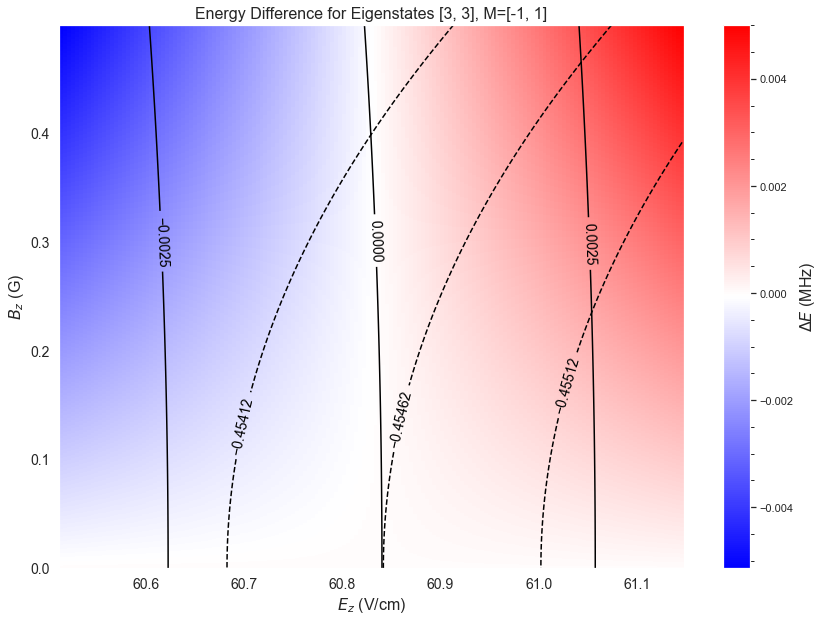

In [156]:
plt.rcParams['contour.negative_linestyle'] = 'solid'

muBgS=1.399624494*2.0023/2
with_contour = True
zoom = True
idx = 0
dE = -evals_match[idx]
dg = -geff_match[idx]/muBgS/2
dPTV = -PTV_match[idx]
Eidx = Ez_idx_match[idx]
Bidx = Bz_idx_match[idx]
eig = eigenstate_match[idx]

El = np.searchsorted(Ez,np.unique(Ez[Eidx]).min())
Eu = np.searchsorted(Ez,np.unique(Ez[Eidx]).max())
Bl = np.searchsorted(Bz,np.unique(Bz[Bidx]).min())
Bu = np.searchsorted(Bz,np.unique(Bz[Bidx]).max())
s1 = slice(El,Eu)
s2 = slice(Bl,Bu)

plt.figure(figsize=(14,10))
plt.grid(False)
if zoom:
    plt.pcolormesh(*mesh[:,s1,s2],dE[s1,s2],shading='auto',cmap='bwr')
else:
    plt.pcolormesh(*mesh,dg,shading='auto',cmap='seismic',norm=TwoSlopeNorm(0,vmin=-1,vmax=1))
cbar = plt.colorbar()#(extend='both')
cbar.minorticks_on()
if zoom:
    cbar.set_label(label=r'$\Delta E$ (MHz)',size=16)
else:
    cbar.set_label(label=r'$\Delta g/2\mu_B$',size=16)
if with_contour:
    try:
        if zoom:
            conmap = plt.contour(*mesh[:,s1,s2],dg[s1,s2],colors=['black'],levels=np.linspace(-0.0025,0.0025,3))#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
            plt.clabel(conmap, inline=True, fontsize=14,manual=[(60.6,0.3),(60.8,0.3),(61.1,0.3)])
            conmap2 = plt.contour(*mesh[:,s1,s2],dPTV[s1,s2],colors=['black'],levels=[dPTV[460,0]-0.0005,dPTV[460,0],dPTV[460,0]+0.0005],linestyles='dashed')#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
            plt.clabel(conmap2, inline=True, fontsize=14,manual=[(60.6,0.15),(60.8,0.15),(61.1,0.15)])
        else:
            conmap = plt.contour(*mesh[:,:,1:],dg[:,1:],colors=['black'],levels=[-0.1,0,.1],linestyles=['dashed','solid','dashed'])#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
            plt.clabel(conmap, inline=True,inline_spacing=10, fontsize=12)
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
if zoom:
    plt.title('Energy Difference for Eigenstates {}, M={}'.format(eig,M_match[idx]),size=16)
else:
    plt.title('normalized Gfactor Difference for Eigenstates {}, M={}'.format(eig,M_match[idx]),size=16)
plt.xlabel(r'$E_z$ (V/cm)',size=16)
plt.ylabel(r'$B_z$ (G)',size=16)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

60.84184184184184


Text(0, 0.5, 'normalized g-factor difference ($\\Delta g/2\\mu_B$)')

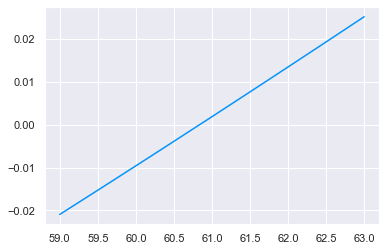

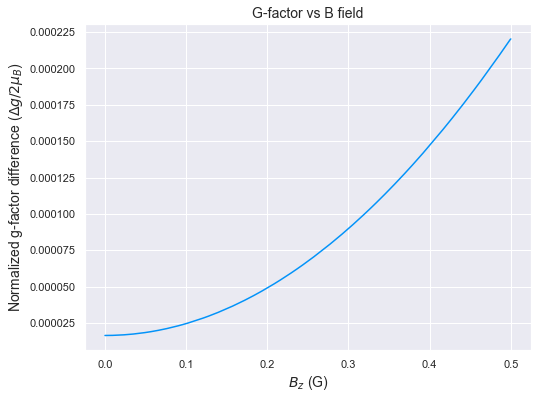

In [157]:
minidx = np.argmin(abs(dg[:,0]))
print(Ez[minidx])
plt.figure()
plt.plot(Ez,dg[:,0])
plt.figure(figsize=(8,6))
plt.title('G-factor vs B field',size=14)
plt.plot(Bz,dg[minidx,:])
plt.xlabel(r'$B_z$ (G)',size=14)
plt.ylabel(r'normalized g-factor difference ($\Delta g/2\mu_B$)',size=14)

In [158]:
from scipy.optimize import curve_fit

def fitFunction(xscale,data,function,guess,sigma,plot,bounds=None):
    xscale = np.array(xscale)
    data = np.array(data)
    guess = np.array(guess).astype(float)
    if bounds==None:
        bounds = (-np.inf,np.inf)
    try:
        popt,pcov = curve_fit(function,xscale,data,p0=guess,sigma=sigma,bounds=bounds)
        perr = np.round(np.sqrt((np.diag(pcov))),decimals=6)
        params = np.round(popt,decimals=6)
        fit = function(xscale,*popt)
        residuals = data - fit
        if plot:
            plotFitComparison(xscale,data,function,params,sigma)
            plotFitResiduals(xscale,residuals,sigma)
    except RuntimeError:
        print("Error - curve_fit failed")
        print(guess)
        plt.figure()
        plt.plot(xscale,data)
        plt.plot(xscale,function(xscale,*guess))
        params = []
        perr = []
        residuals = []
    return [params,perr,residuals]

def fitPower(xscale, data,guess=[1,0],sigma=None,plot=True,verbose=False):
    function = power
    bounds = ([0,0],[np.inf,np.inf])
    params,error,residuals = fitFunction(xscale,data,function,guess,sigma,plot)
    if verbose:
        print('Norm = {} +/- {}'.format(params[0],error[0]))
        print('Power = {} +/- {}'.format(params[1],error[1]))
    return [params,error,residuals]

def power(x,a,b):
    return a*x**b

def quadratic(x,a):
    return a*x**2

def fitQuad(xscale, data,guess=[1],sigma=None,plot=True,verbose=False):
    function = quadratic
    params,error,residuals = fitFunction(xscale,data,function,guess,sigma,plot)
    if verbose:
        print('Norm = {} +/- {}'.format(params[0],error[0]))
    return [params,error,residuals]

def plotFitComparison(xscale,data,function,params,sigma,xlabel=None,ylabel=None):
    plt.figure()
    plt.title('Fit vs Data')
    if sigma is None:
        plt.plot(xscale,data,label='Data',marker='o')
    else:
        plt.errorbar(xscale,data,yerr=sigma,label='Data',marker='o',linestyle='None')
    plt.plot(xscale,function(xscale,*params),label='Fit')
    return

def plotFitResiduals(xscale,residuals,sigma):
    plt.figure()
    plt.title('Fit Residuals')
    if sigma is None:
        plt.plot(xscale,residuals,'o',linestyle='None')
    else:
        plt.errorbar(xscale,residuals,yerr=sigma,marker='o',linestyle='None')
    plt.plot(xscale,np.zeros(len(xscale)),linestyle='--')
    return

In [159]:
dg[minidx,0]

1.6321974643556303e-05

Norm = 0.000818 +/- 0.0


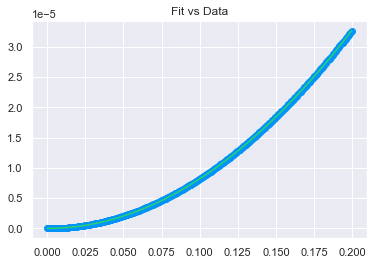

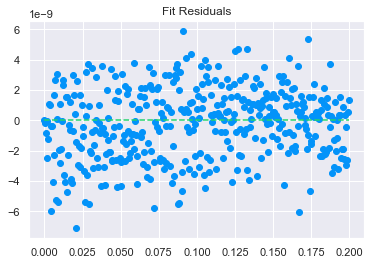

In [160]:
params,err,resid = fitQuad(Bz[:np.searchsorted(Bz,0.2)],dg[minidx,:np.searchsorted(Bz,0.2)]-dg[minidx,0],guess=[1],verbose=True)

In [161]:
params

array([0.00082])

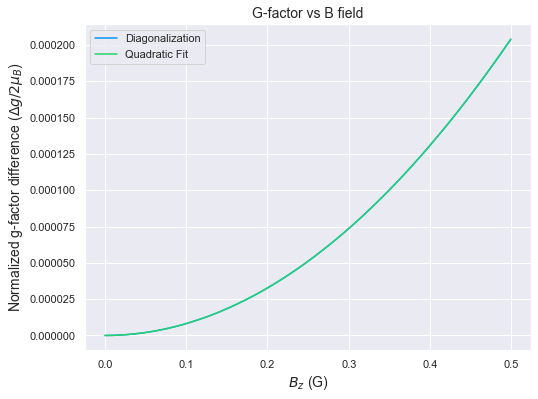

In [162]:
Bu=0.5
plt.figure(figsize=(8,6))
plt.title('G-factor vs B field',size=14)
plt.plot(Bz[:np.searchsorted(Bz,Bu)],dg[minidx,:np.searchsorted(Bz,Bu)]-dg[minidx,0],label='Diagonalization')
plt.plot(Bz[:np.searchsorted(Bz,Bu)],quadratic(Bz[:np.searchsorted(Bz,Bu)],*params),label='Quadratic Fit')
plt.xlabel(r'$B_z$ (G)',size=14)
plt.ylabel(r'normalized g-factor difference ($\Delta g/2\mu_B$)',size=14)
plt.legend(loc='best');

C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_8928/2268906481.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(extend='both')
posx and posy should be finite values


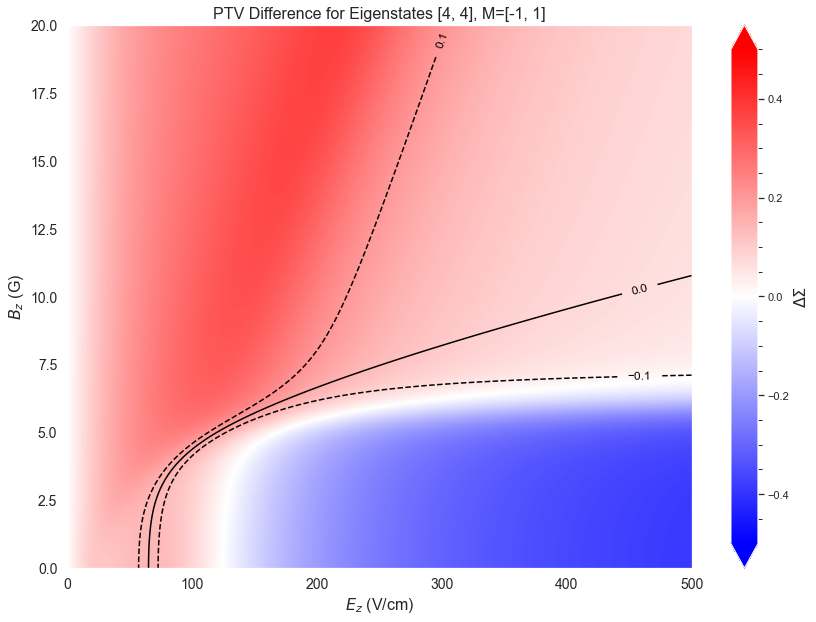

In [101]:
plt.rcParams['contour.negative_linestyle'] = 'solid'

muBgS=1.399624494*2.0023/2
with_contour = True
zoom = False
idx = 3
dE = -evals_match[idx]
dg = -geff_match[idx]/muBgS/2
dPTV = -PTV_match[idx]
Eidx = Ez_idx_match[idx]
Bidx = Bz_idx_match[idx]
eig = eigenstate_match[idx]

El = np.searchsorted(Ez,np.unique(Ez[Eidx]).min())
Eu = np.searchsorted(Ez,np.unique(Ez[Eidx]).max())
Bl = np.searchsorted(Bz,np.unique(Bz[Bidx]).min())
Bu = np.searchsorted(Bz,np.unique(Bz[Bidx]).max())
s1 = slice(El,Eu)
s2 = slice(Bl,Bu)

plt.figure(figsize=(14,10))
plt.grid(False)
if zoom:
    plt.pcolormesh(*mesh[:,s1,s2],dE[s1,s2],shading='auto',cmap='bwr')
else:
    plt.pcolormesh(*mesh,dPTV,shading='auto',cmap='bwr',norm=TwoSlopeNorm(0,vmin=-0.5,vmax=0.5))
cbar = plt.colorbar(extend='both')
cbar.minorticks_on()
cbar.set_label(label=r'$\Delta \Sigma$',size=16)
if with_contour:
    try:
        if zoom:
            conmap = plt.contour(*mesh[:,s1,s2],dg[s1,s2],colors=['black'],levels=np.linspace(-0.0025,0.0025,3))#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
            plt.clabel(conmap, inline=True, fontsize=12,manual=[(60.6,0.3),(60.8,0.3),(61.1,0.3)])
            conmap2 = plt.contour(*mesh[:,s1,s2],dPTV[s1,s2],colors=['black'],levels=[dPTV[460,0]-0.0005,dPTV[460,0],dPTV[460,0]+0.0005],linestyles='dashed')#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
            plt.clabel(conmap2, inline=True, fontsize=12,manual=[(60.6,0.15),(60.8,0.15),(61.1,0.15)])
        else:
            conmap = plt.contour(*mesh[:,:,1:],dg[:,1:],colors=['black'],levels=[-0.1,0,.1],linestyles=['dashed','solid','dashed'])#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
            plt.clabel(conmap, inline=True,inline_spacing=10, fontsize=12)
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('PTV Difference for Eigenstates {}, M={}'.format(eig,M_match[idx]),size=16)
plt.xlabel(r'$E_z$ (V/cm)',size=16)
plt.ylabel(r'$B_z$ (G)',size=16)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_8928/3098276400.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(extend='both')


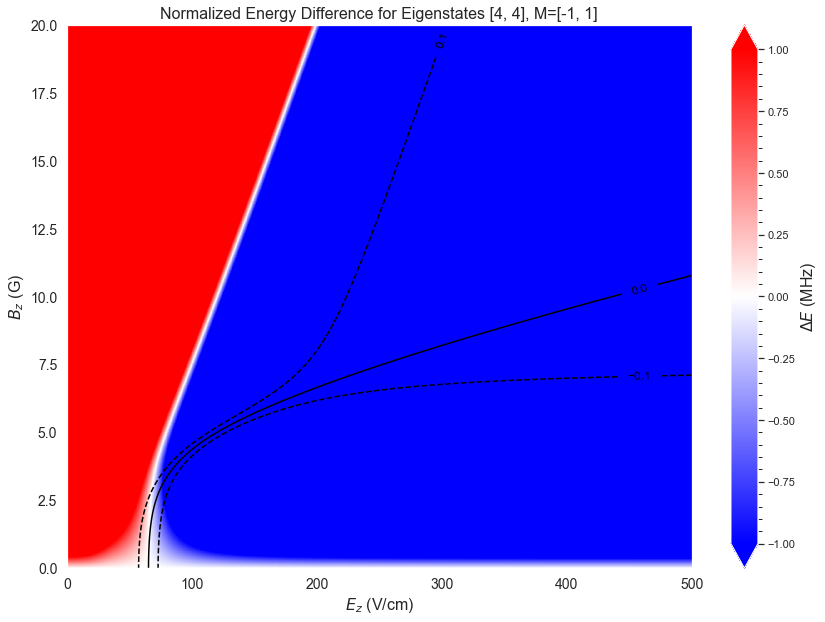

In [63]:
plt.rcParams['contour.negative_linestyle'] = 'solid'

muBgS=1.399624494*2.0023/2
with_contour = True
zoom = False
idx = 3
dE = -evals_match[idx]
dg = -geff_match[idx]/muBgS/2
dPTV = -PTV_match[idx]
Eidx = Ez_idx_match[idx]
Bidx = Bz_idx_match[idx]
eig = eigenstate_match[idx]

El = np.searchsorted(Ez,np.unique(Ez[Eidx]).min())
Eu = np.searchsorted(Ez,np.unique(Ez[Eidx]).max())
Bl = np.searchsorted(Bz,np.unique(Bz[Bidx]).min())
Bu = np.searchsorted(Bz,np.unique(Bz[Bidx]).max())
s1 = slice(El,Eu)
s2 = slice(Bl,Bu)

plt.figure(figsize=(14,10))
plt.grid(False)
if zoom:
    plt.pcolormesh(*mesh[:,s1,s2],dE[s1,s2],shading='auto',cmap='bwr')
else:
    plt.pcolormesh(*mesh,dE,shading='auto',cmap='bwr',norm=TwoSlopeNorm(0,vmin=-1,vmax=1))
cbar = plt.colorbar(extend='both')
cbar.minorticks_on()
cbar.set_label(label=r'$\Delta E$ (MHz)',size=16)
if with_contour:
    try:
        if zoom:
            conmap = plt.contour(*mesh[:,s1,s2],dg[s1,s2],colors=['black'],levels=np.linspace(-0.0025,0.0025,3))#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
            plt.clabel(conmap, inline=True, fontsize=12,manual=[(60.6,0.3),(60.8,0.3),(61.1,0.3)])
            conmap2 = plt.contour(*mesh[:,s1,s2],dPTV[s1,s2],colors=['black'],levels=[dPTV[460,0]-0.0005,dPTV[460,0],dPTV[460,0]+0.0005],linestyles='dashed')#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
            plt.clabel(conmap2, inline=True, fontsize=12,manual=[(60.6,0.15),(60.8,0.15),(61.1,0.15)])
        else:
            conmap = plt.contour(*mesh[:,:,1:],dg[:,1:],colors=['black'],levels=[-0.1,0,.1],linestyles=['dashed','solid','dashed'])#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
            plt.clabel(conmap, inline=True,inline_spacing=10, fontsize=12)
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('normalized Energy Difference for Eigenstates {}, M={}'.format(eig,M_match[idx]),size=16)
plt.xlabel(r'$E_z$ (V/cm)',size=16)
plt.ylabel(r'$B_z$ (G)',size=16)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_8928/2309081722.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(extend='both')


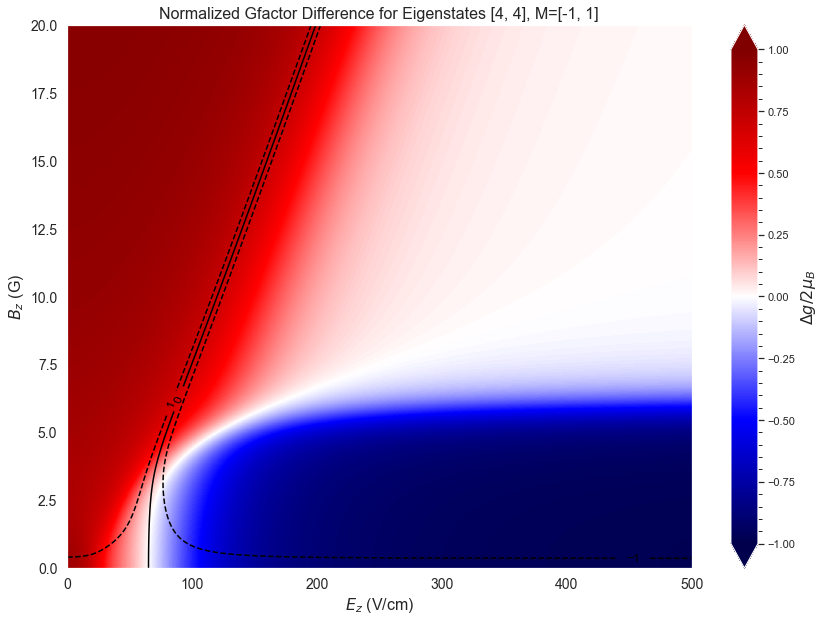

In [65]:
plt.rcParams['contour.negative_linestyle'] = 'solid'

muBgS=1.399624494*2.0023/2
with_contour = True
zoom = False
idx = 3
dE = -evals_match[idx]
dg = -geff_match[idx]/muBgS/2
dPTV = -PTV_match[idx]
Eidx = Ez_idx_match[idx]
Bidx = Bz_idx_match[idx]
eig = eigenstate_match[idx]

El = np.searchsorted(Ez,np.unique(Ez[Eidx]).min())
Eu = np.searchsorted(Ez,np.unique(Ez[Eidx]).max())
Bl = np.searchsorted(Bz,np.unique(Bz[Bidx]).min())
Bu = np.searchsorted(Bz,np.unique(Bz[Bidx]).max())
s1 = slice(El,Eu)
s2 = slice(Bl,Bu)

plt.figure(figsize=(14,10))
plt.grid(False)
if zoom:
    plt.pcolormesh(*mesh[:,s1,s2],dE[s1,s2],shading='auto',cmap='bwr')
else:
    plt.pcolormesh(*mesh,dg,shading='auto',cmap='seismic',norm=TwoSlopeNorm(0,vmin=-1,vmax=1))
cbar = plt.colorbar(extend='both')
cbar.minorticks_on()
cbar.set_label(label=r'$\Delta g/2\mu_B$',size=16)
if with_contour:
    try:
        if zoom:
            conmap = plt.contour(*mesh[:,s1,s2],dg[s1,s2],colors=['black'],levels=np.linspace(-0.0025,0.0025,3))#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
            plt.clabel(conmap, inline=True, fontsize=12,manual=[(60.6,0.3),(60.8,0.3),(61.1,0.3)])
            conmap2 = plt.contour(*mesh[:,s1,s2],dPTV[s1,s2],colors=['black'],levels=[dPTV[460,0]-0.0005,dPTV[460,0],dPTV[460,0]+0.0005],linestyles='dashed')#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
            plt.clabel(conmap2, inline=True, fontsize=12,manual=[(60.6,0.15),(60.8,0.15),(61.1,0.15)])
        else:
            conmap = plt.contour(*mesh[:,:,1:],dE[:,1:],colors=['black'],levels=[-1,0,1],linestyles=['dashed','solid','dashed'])#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
            plt.clabel(conmap, inline=True,inline_spacing=10, fontsize=12)
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('normalized Gfactor Difference for Eigenstates {}, M={}'.format(eig,M_match[idx]),size=16)
plt.xlabel(r'$E_z$ (V/cm)',size=16)
plt.ylabel(r'$B_z$ (G)',size=16)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

In [44]:
i=4
X010 = state_dict[1]
X010.eigensystem(0,0)
print('Decoupled:')
display(Latex(X010.gen_state_str(i,basis='decoupled',thresh=0.05,label_q=['K','M_N','M_S','M_I','M_F'],round=4)))
print('Case A:')
display(Latex(X010.gen_state_str(i,basis='aBJ',thresh=0.05,label_q=['K','J','F','Sigma','P','M'],round=4)))
print('Case B:')
display(Latex(X010.gen_state_str(i,thresh=0.05,round=4)))
print('\n')

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


Text(0, 0.5, '$B_z$ (G)')

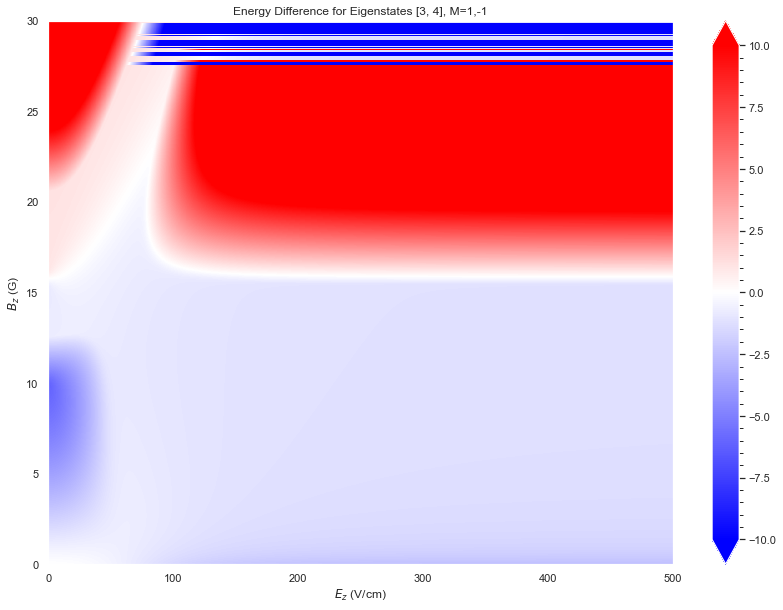

In [295]:
plt.rcParams['contour.negative_linestyle'] = 'solid'

muBgS=1.399624494*2.0023/2
with_contour = False
zoom = False
idx = 1
dE = -evals_match[idx]
dg = -geff_match[idx]/muBgS/2
dPTV = -PTV_match[idx]
Eidx = Ez_idx_match[idx]
Bidx = Bz_idx_match[idx]
eig = eigenstate_match[idx]

El = np.searchsorted(Ez,np.unique(Ez[Eidx]).min())
Eu = np.searchsorted(Ez,np.unique(Ez[Eidx]).max())
Bl = np.searchsorted(Bz,np.unique(Bz[Bidx]).min())
Bu = np.searchsorted(Bz,np.unique(Bz[Bidx]).max())
s1 = slice(El,Eu)
s2 = slice(Bl,Bu)

plt.figure(figsize=(14,10))
plt.grid(False)
if zoom:
    plt.pcolormesh(*mesh[:,s1,s2],dE[s1,s2],shading='auto',cmap='seismic')
else:
    plt.pcolormesh(*mesh,dE,shading='auto',cmap='bwr',norm=TwoSlopeNorm(0,vmin=-10,vmax=10))
cbar = plt.colorbar(extend='both')
cbar.minorticks_on()
if with_contour:
    try:
        if zoom:
            conmap = plt.contour(*mesh[:,s1,s2],dg[s1,s2],colors=['grey'],levels=10)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
            plt.clabel(conmap, inline=True, fontsize=12)
        else:
            conmap = plt.contour(*mesh,dg,colors=['black'],levels=[-0.1,0,0.1],linestyles=['dashed','solid','dashed'])#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
            plt.clabel(conmap, inline=True,inline_spacing=10, fontsize=12)
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('Energy Difference for Eigenstates {}, M=1,-1'.format(eig))
plt.xlabel(r'$E_z$ (V/cm)')
plt.ylabel(r'$B_z$ (G)')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


Text(0, 0.5, '$B_z$ (G)')

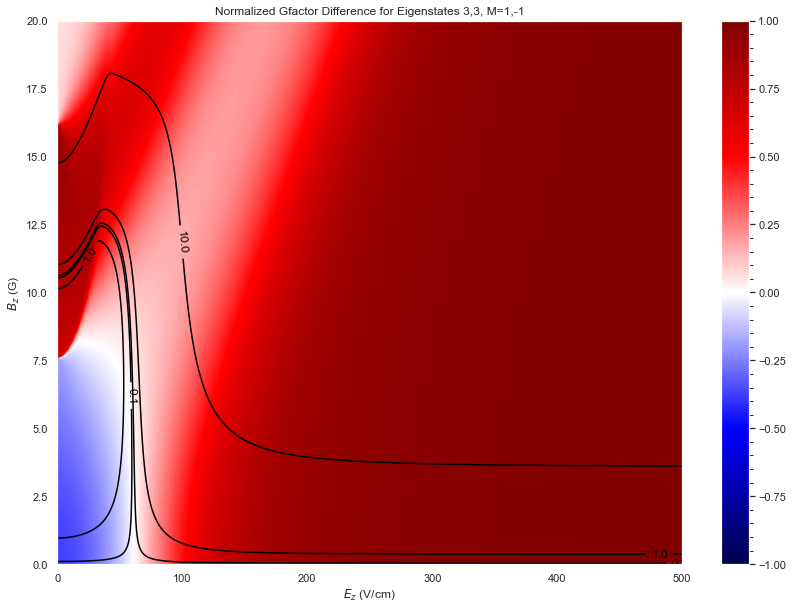

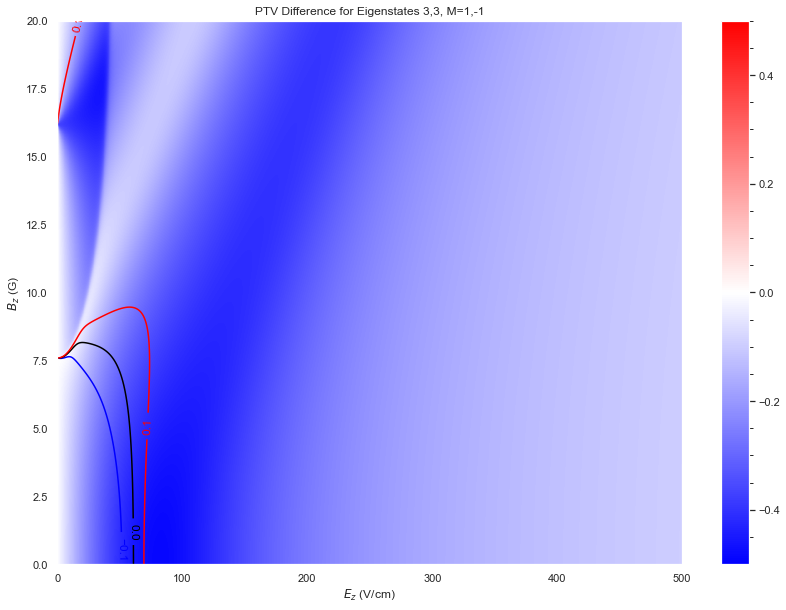

In [24]:
muBgS=1.399624494*2.0023/2
with_contour = True
idx = 3
evals_1 = eval_dict[1][idx]
evals_2 = eval_dict[-1][idx]
plt.figure(figsize=(14,10))
geff_1 = np.gradient(evals_1)[1]/(Bz[1]-Bz[0])
geff_2 = np.gradient(evals_2)[1]/(Bz[1]-Bz[0])
delta_geff = geff_1 - geff_2
delta_E = evals_1 - evals_2
plt.grid(False)
plt.pcolormesh(*mesh,delta_geff/(2*muBgS),shading='auto',cmap='seismic',vmin=-1,vmax=1)
cbar = plt.colorbar()
cbar.minorticks_on()
if with_contour:
    try:
        conmap = plt.contour(*mesh,abs(delta_E),colors=['black'],levels=[-10,-1,-0.1,0.1,1,10])#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap, inline=True, fontsize=12)
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('normalized Gfactor Difference for Eigenstates {},{}, M=1,-1'.format(idx,idx))
plt.xlabel(r'$E_z$ (V/cm)')
plt.ylabel(r'$B_z$ (G)')

PTV_1 = PTV_dict[1][idx]
PTV_2 = PTV_dict[-1][idx]
plt.figure(figsize=(14,10))
delta_PTV = PTV_1 - PTV_2
plt.grid(False)
plt.pcolormesh(*mesh,delta_PTV,shading='auto',cmap='bwr',vmin=-0.5,vmax=0.5)
cbar = plt.colorbar()
cbar.minorticks_on()
if with_contour:
    try:
        conmap2 = plt.contour(*mesh,delta_geff/(2*muBgS),colors=['blue','black','red'],levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap2, inline=True, fontsize=12)
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('PTV Difference for Eigenstates {},{}, M=1,-1'.format(idx,idx))
plt.xlabel(r'$E_z$ (V/cm)')
plt.ylabel(r'$B_z$ (G)')

(0.0, 0.1)

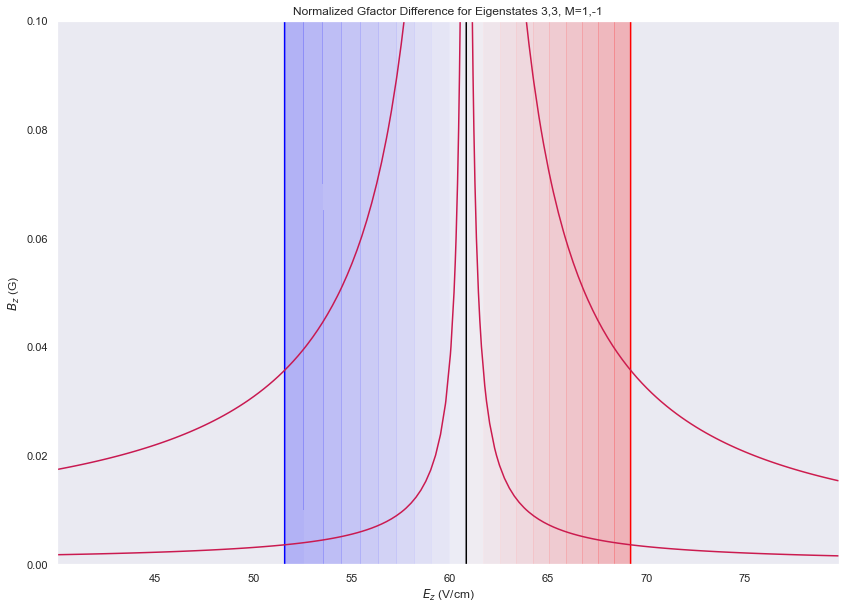

In [37]:
El = np.searchsorted(Ez,40)
Eu = np.searchsorted(Ez,80)
Bl = np.searchsorted(Bz,0)
Bu = np.searchsorted(Bz,4)
s1 = slice(El,Eu)
s2 = slice(Bl,Bu)


muBgS=1.399624494*2.0023/2
with_contour = True
idx = 3
evals_1 = eval_dict[1][idx]
evals_2 = eval_dict[-1][idx]
plt.figure(figsize=(14,10))
geff_1 = np.gradient(evals_1)[1]/(Bz[1]-Bz[0])
geff_2 = np.gradient(evals_2)[1]/(Bz[1]-Bz[0])
delta_geff = geff_1 - geff_2
delta_E = evals_1 - evals_2
plt.grid(False)
# PTV_1 = PTV_dict[1][idx]
# PTV_2 = PTV_dict[-1][idx]
# delta_PTV = PTV_1 - PTV_2
# plt.contourf(*mesh[:,s1,s2],delta_PTV[s1,s2],levels=10,cmap='cool')
# cbar = plt.colorbar()
# cbar.minorticks_on()
if with_contour:
    try:
        conmap1 = plt.contour(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS/2,colors=['blue','black','red'],levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap1, inline=True,inline_spacing=5,manual=[(50,3.5),(60,3.5),(70,3.5)], fontsize=14,rightside_up=False)
        smallmap1 = plt.contourf(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS/2,cmap='bwr',levels=np.linspace(-0.1,0.1,21),alpha=0.25,vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        conmap3 = plt.contour(*mesh[:,s1,s2],delta_E[s1,s2],levels=[-1,-0.1,-0.01,-0.001,0.001,0.01,0.1,1])
#         plt.clabel(conmap3, inline=True,inline_spacing=5, fontsize=14,rightside_up=False)
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('normalized Gfactor Difference for Eigenstates {},{}, M=1,-1'.format(idx,idx))
plt.xlabel(r'$E_z$ (V/cm)')
plt.ylabel(r'$B_z$ (G)')

# idx = 4
# evals_1 = eval_dict[1][idx]
# evals_2 = eval_dict[-1][idx]
# geff_1 = np.gradient(evals_1)[1]/(Bz[1]-Bz[0])
# geff_2 = np.gradient(evals_2)[1]/(Bz[1]-Bz[0])
# delta_geff = geff_1 - geff_2
# plt.grid(False)
# # plt.pcolormesh(*mesh,delta_geff/muBgS,shading='auto',cmap='seismic',vmin=-1,vmax=1)
# # cbar = plt.colorbar()
# # cbar.minorticks_on()
# if with_contour:
#     try:
#         conmap2 = plt.contour(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS/2,colors=['blue','black','red'],linestyles='dashed',levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
#         plt.clabel(conmap2,inline=True,inline_spacing=5, manual=[(75,3.25),(75,3),(75,2)],fontsize=14,rightside_up=True)
#         smallmap2 = plt.contourf(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS/2,cmap='bwr',linestyles='dashed',levels=np.linspace(-0.1,0.1,21),alpha=0.25,vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
# #             cbar = plt.colorbar()
# #             cbar.minorticks_on()
#     except ValueError:
#         print("Can't plot this data")
plt.ylim(0,.1)

In [ ]:
muBgS=1.399624494*2.0023/2
with_contour = True
for M in eval_dict.keys():
    if abs(M)==2:
        continue
    print(M)
    evals_EB = eval_dict[M]
    for i in range(len(evals_EB)):
        plt.figure(figsize=(14,10))
        geff = np.gradient(evals_EB[i])[1]/(Bz[1]-Bz[0])
        plt.grid(False)
        plt.pcolormesh(*mesh,geff/muBgS,shading='auto',cmap='seismic',vmin=-1,vmax=1)
        cbar = plt.colorbar()
        cbar.minorticks_on()
        if with_contour:
            try:
                conmap = plt.contour(*mesh,geff/muBgS,cmap='seismic',levels=[-0.1,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
                plt.clabel(conmap, inline=True, fontsize=12)
    #             cbar = plt.colorbar()
    #             cbar.minorticks_on()
            except ValueError:
                print("Can't plot this data")
        plt.title('normalized Gfactor for Eigenstate {}, M={}'.format(i,M))
        plt.xlabel(r'$E_z$ (V/cm)')
        plt.ylabel(r'$B_z$ (G)')

-2


C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_17868/4137279930.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


-1
0
1


C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_17868/4137279930.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


2


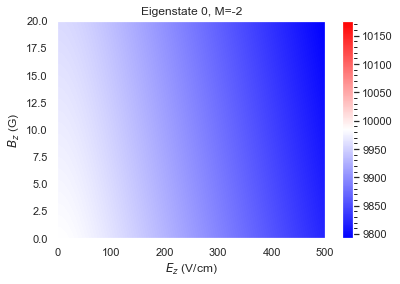

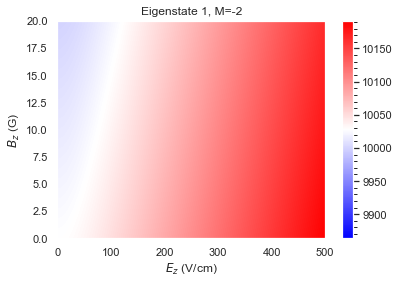

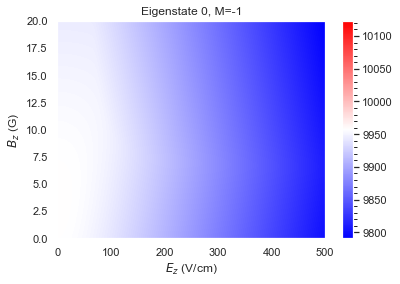

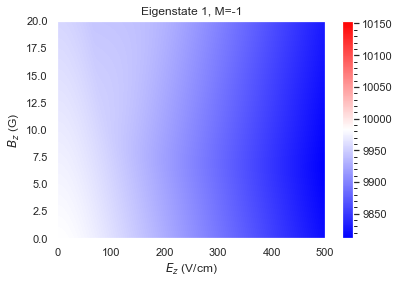

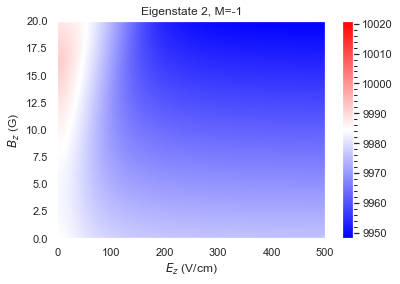

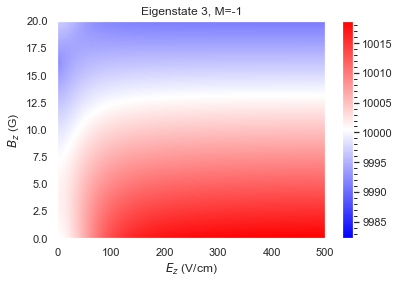

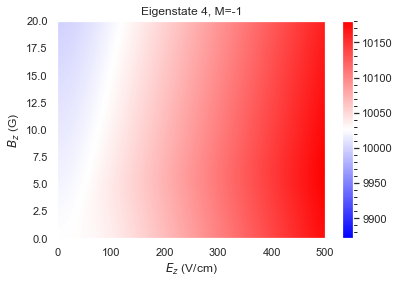

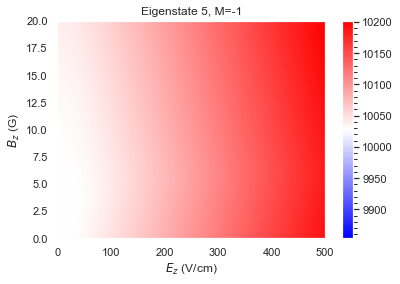

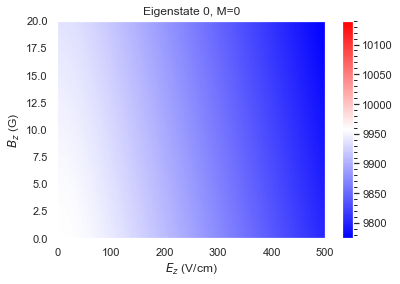

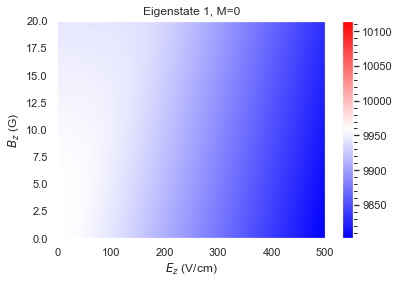

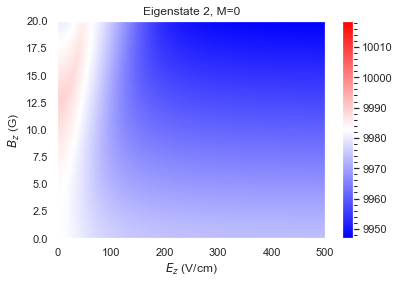

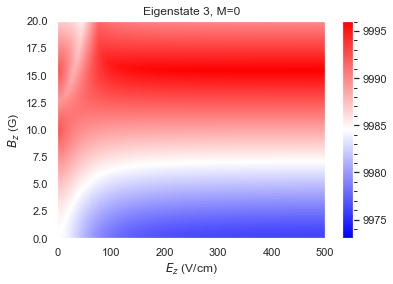

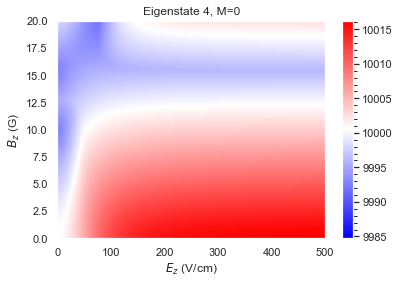

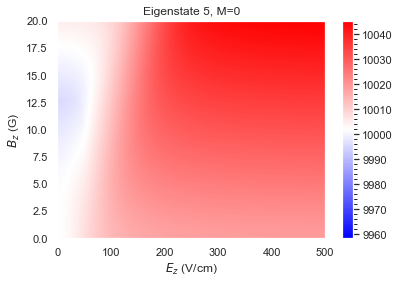

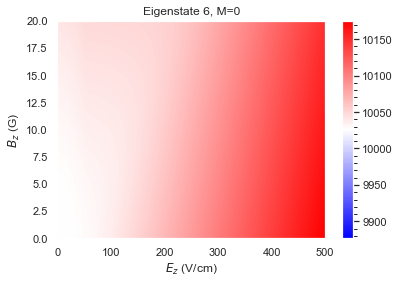

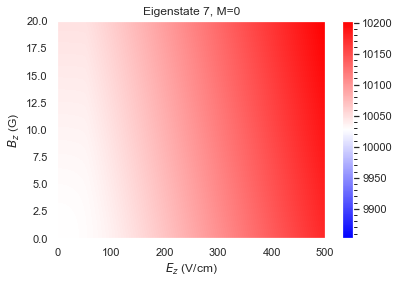

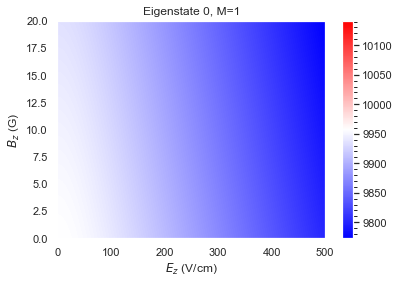

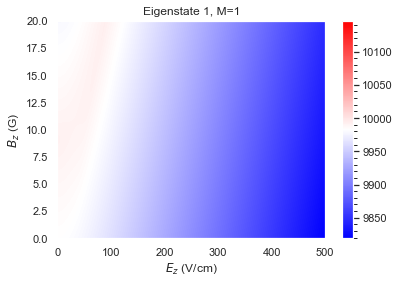

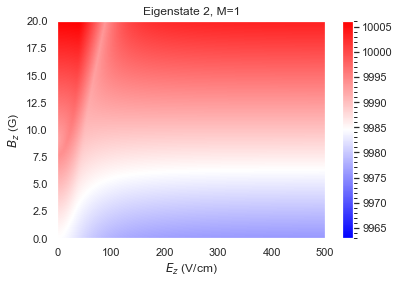

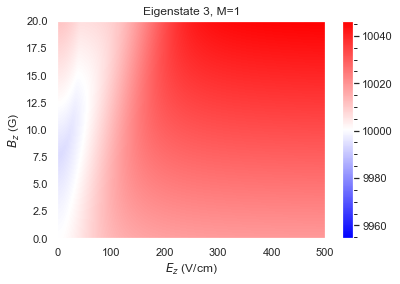

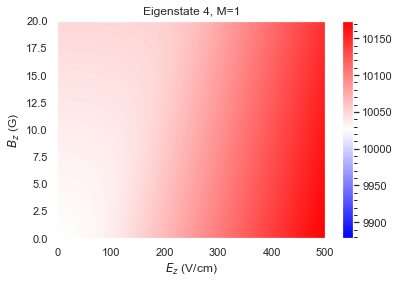

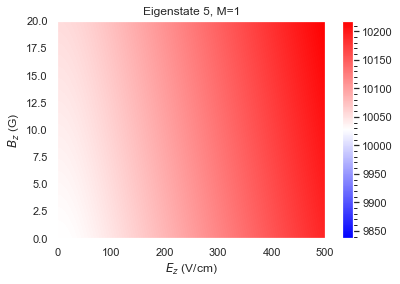

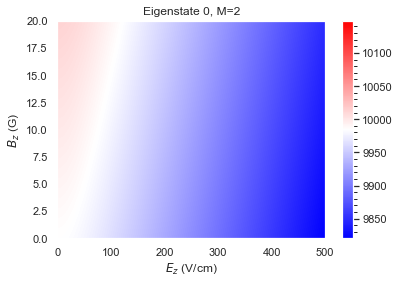

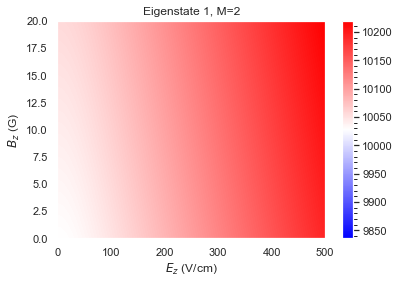

In [41]:
for M in eval_dict.keys():
    print(M)
    evals_EB = eval_dict[M]
    for i in range(len(evals_EB)):
        plt.figure()
        E0 = evals_EB[i][0,0]
        max_delta = max(abs(evals_EB[i].max()-E0),abs(evals_EB[i].min()-E0))
        plt.grid(False)
        plt.pcolormesh(*mesh,evals_EB[i],shading='auto',cmap='bwr',norm=TwoSlopeNorm(vcenter=E0,vmin=E0-max_delta,vmax=E0+max_delta))
        cbar = plt.colorbar()
        cbar.minorticks_on()
        plt.title('Eigenstate {}, M={}'.format(i,M))
        plt.xlabel(r'$E_z$ (V/cm)')
        plt.ylabel(r'$B_z$ (G)')

In [193]:
geff.min()/1.402

-0.9994536823122795

In [202]:
muBgS=1.399624494*2.0023/2

-1


C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_17868/3739572149.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


0
1


C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_17868/3739572149.py:17: UserWarning: No contour levels were found within the data range.
  conmap = plt.contour(*mesh,geff/muBgS,cmap='seismic',levels=[-0.1,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))


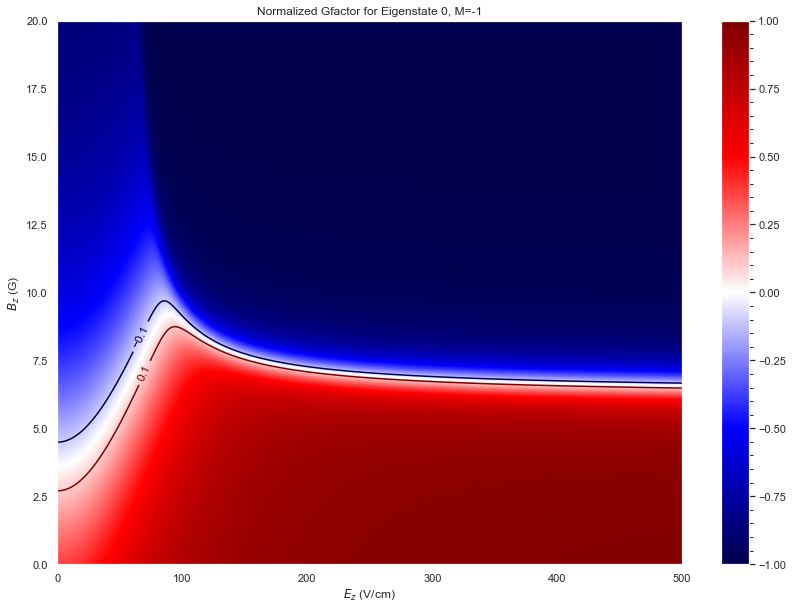

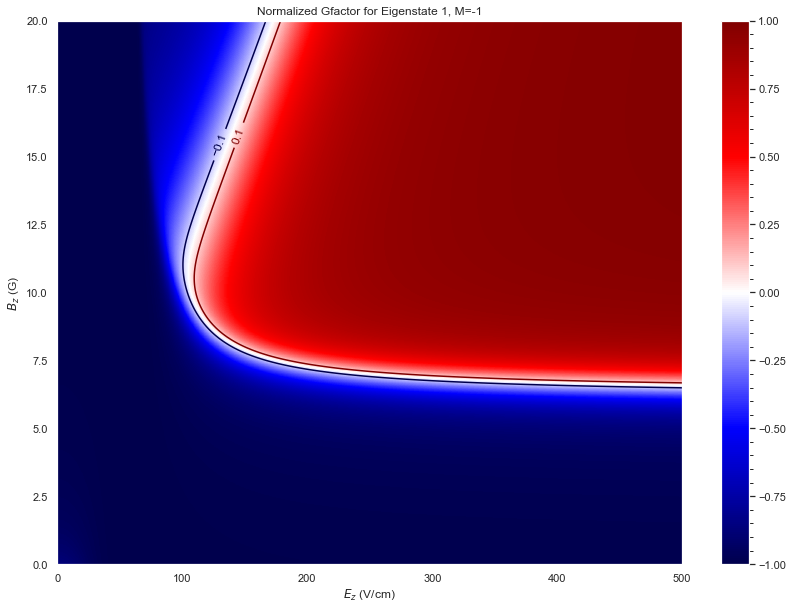

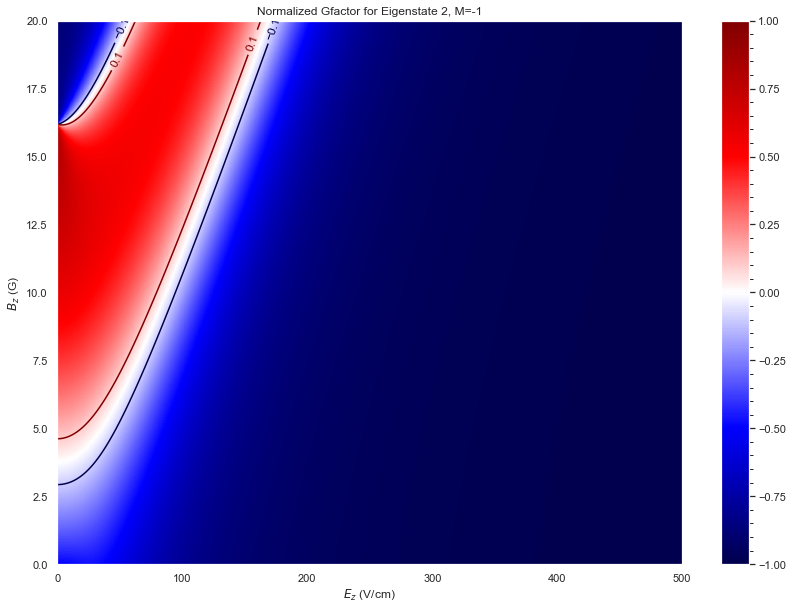

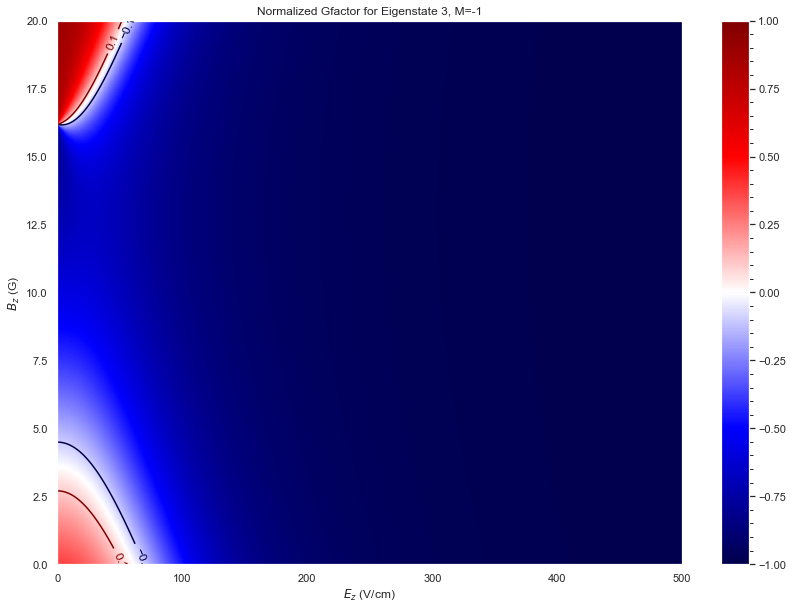

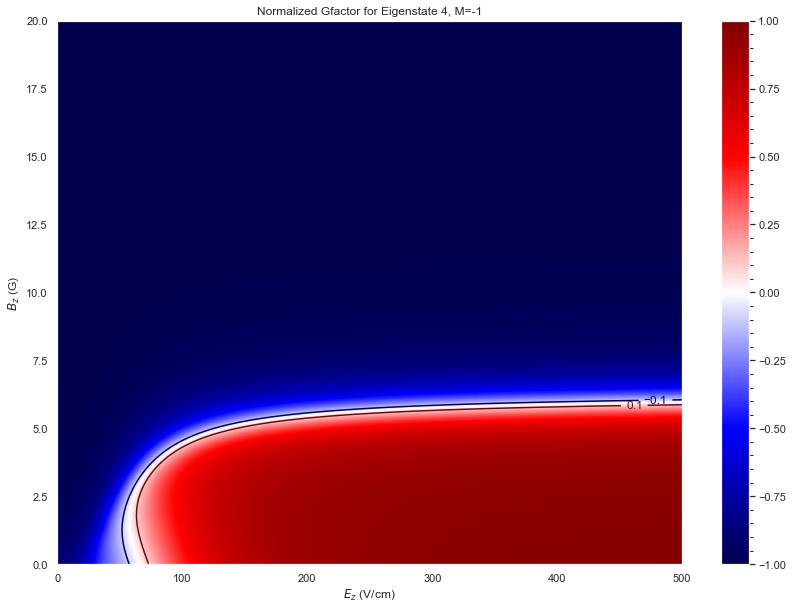

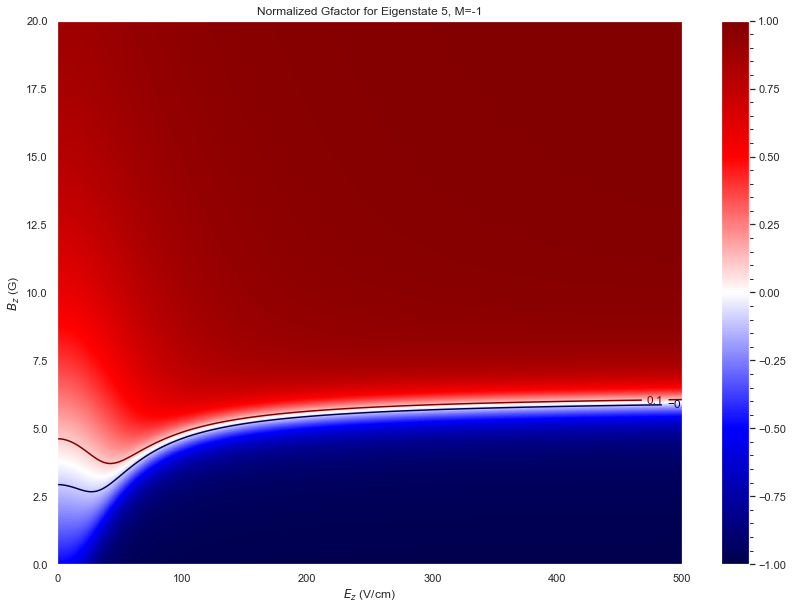

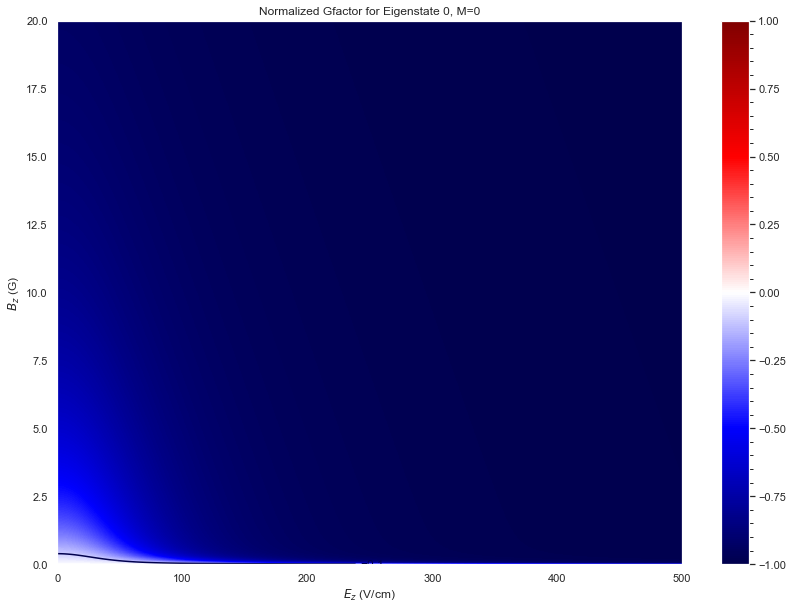

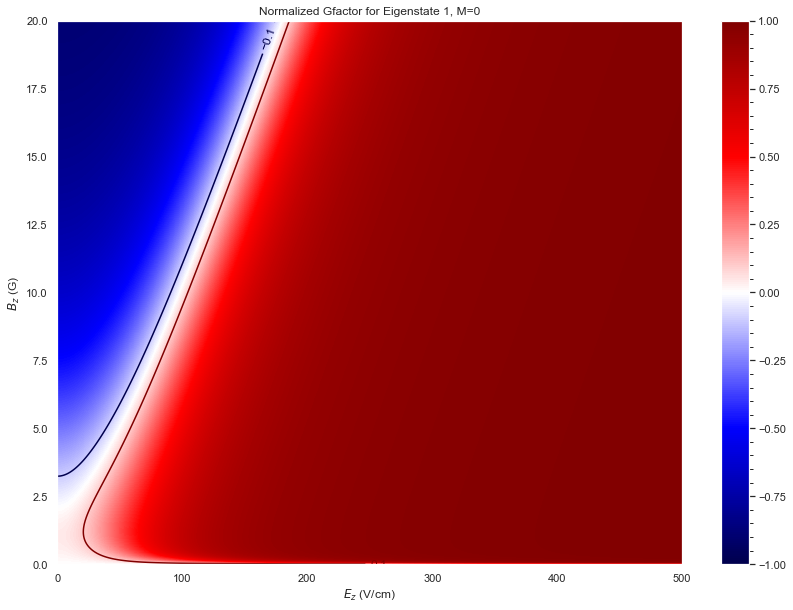

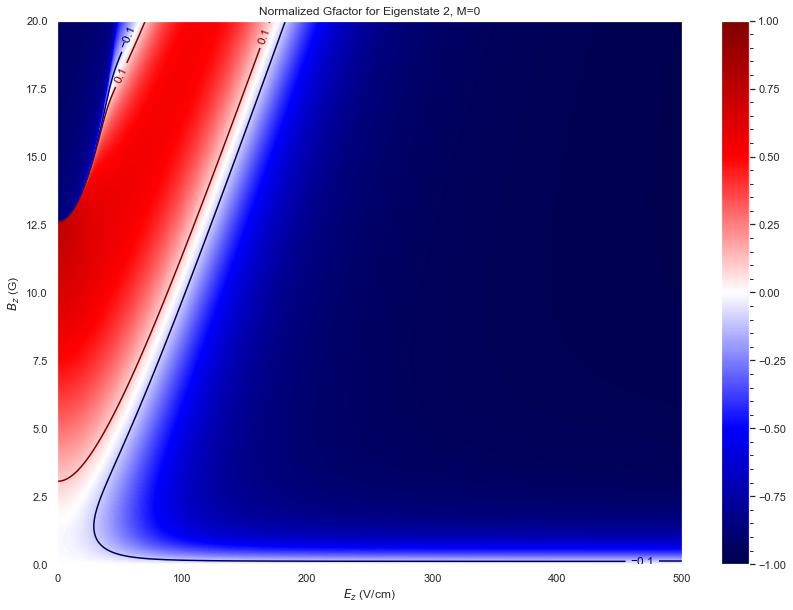

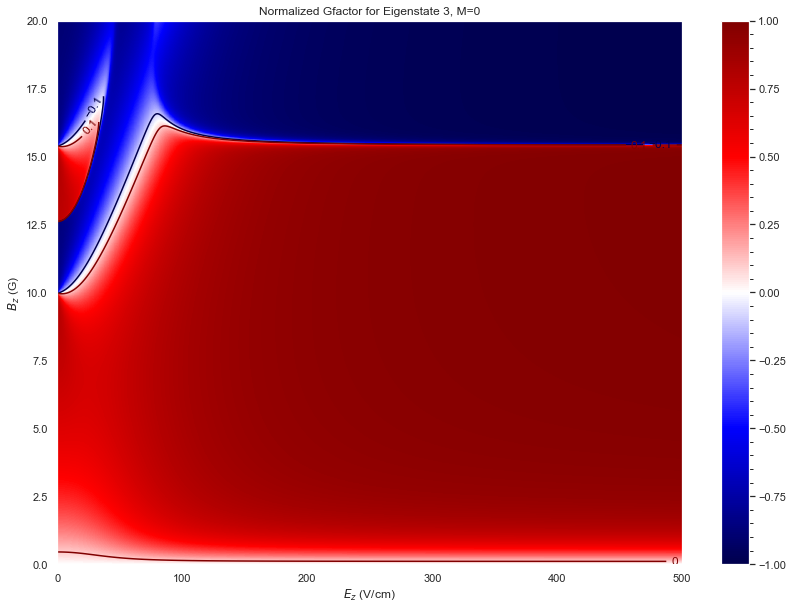

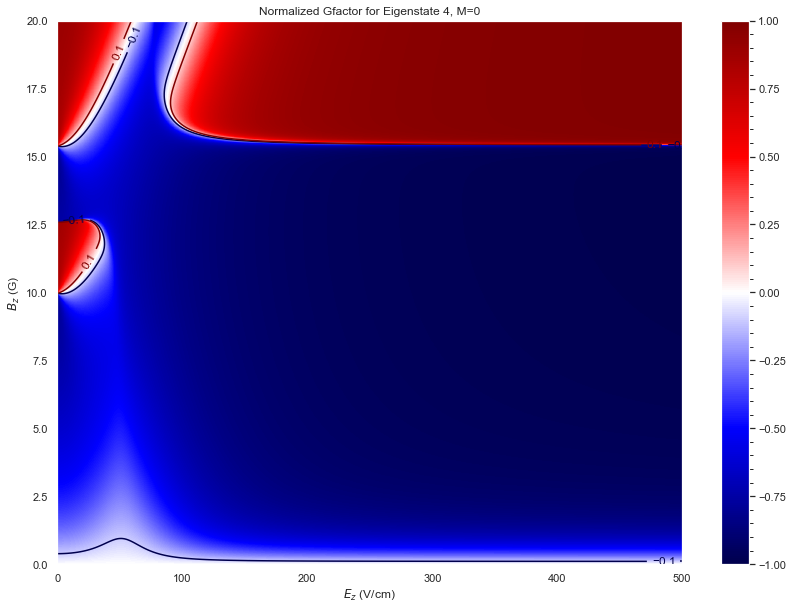

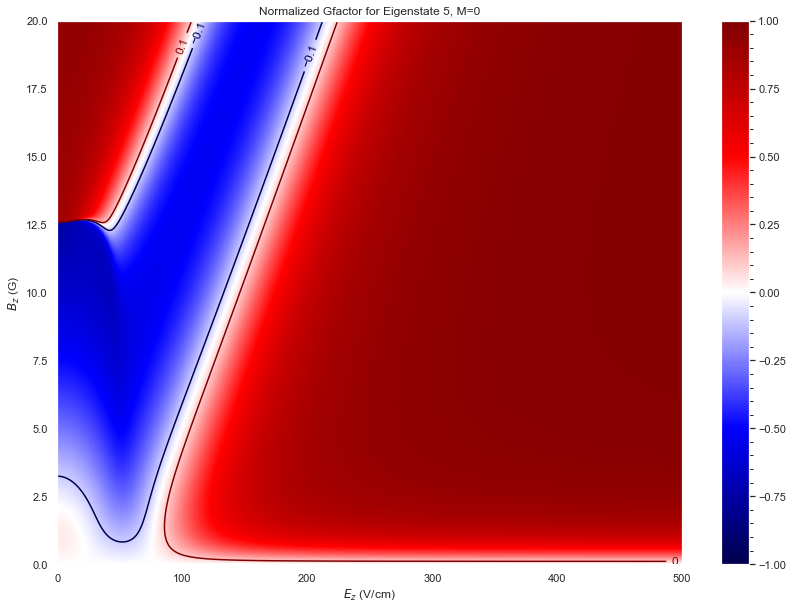

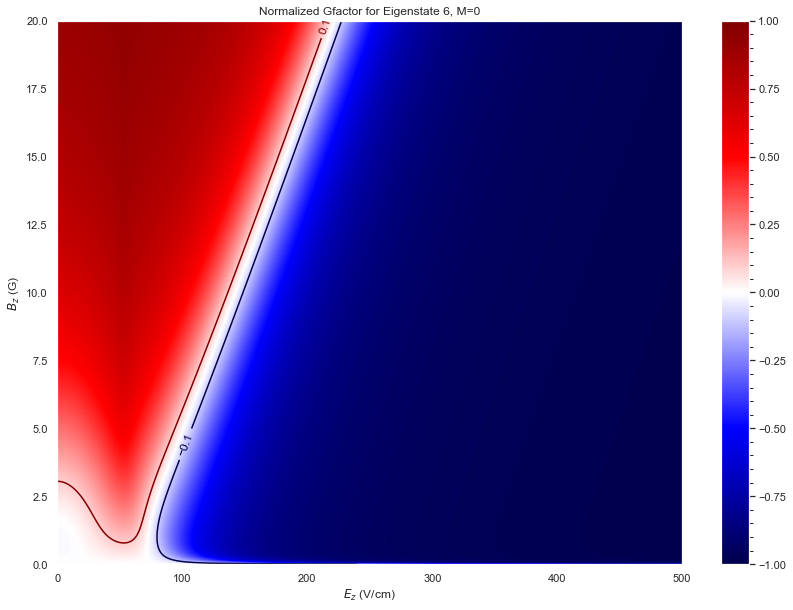

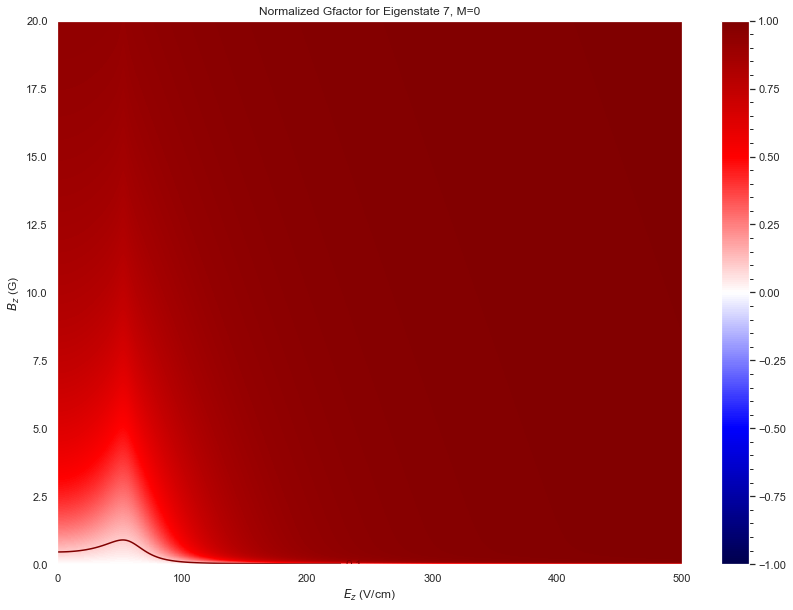

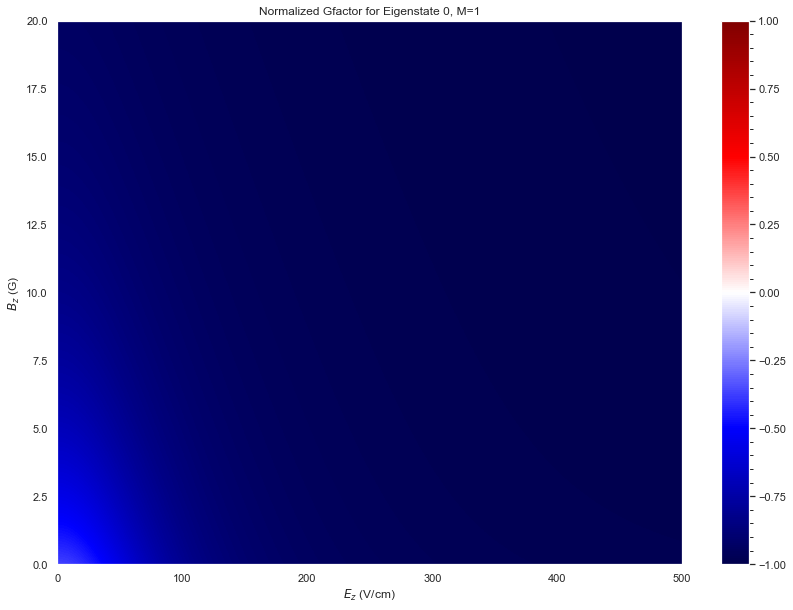

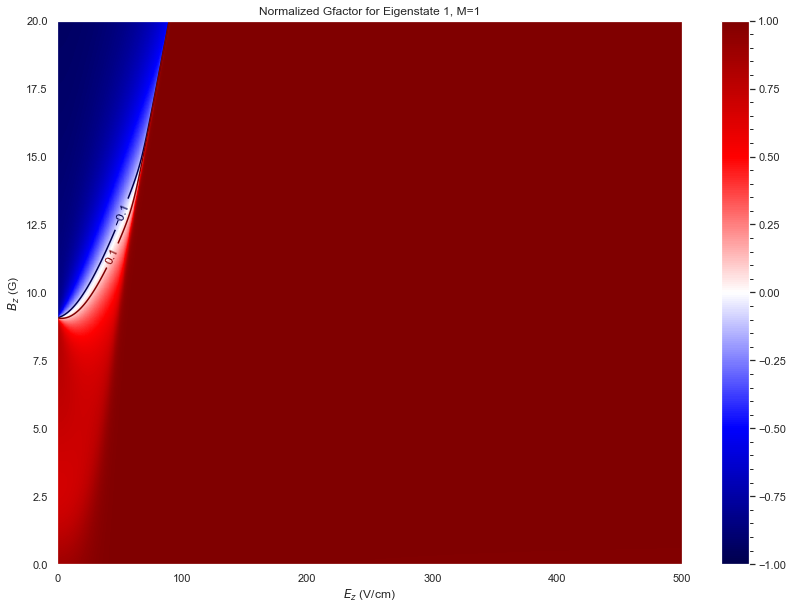

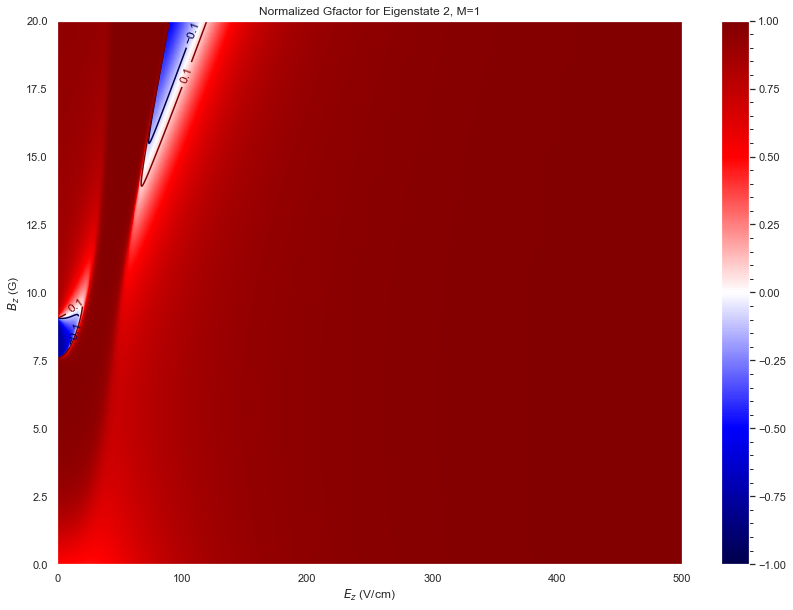

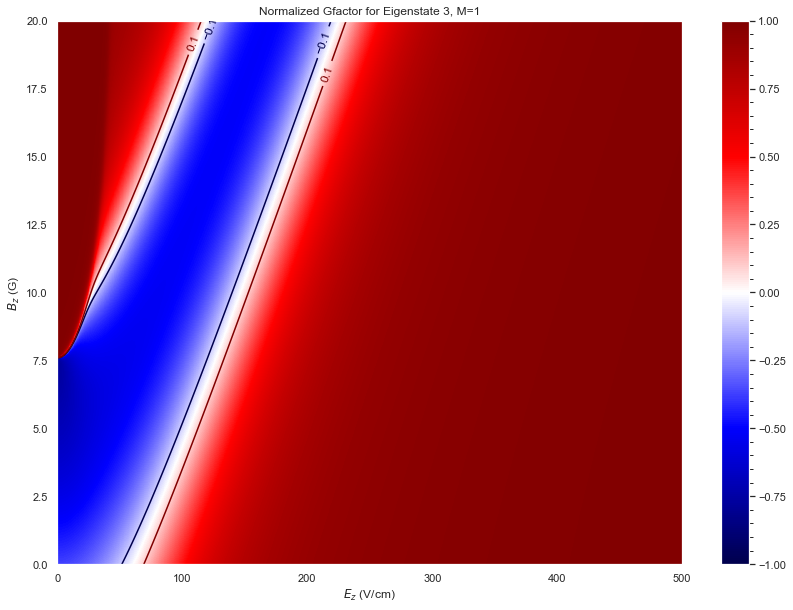

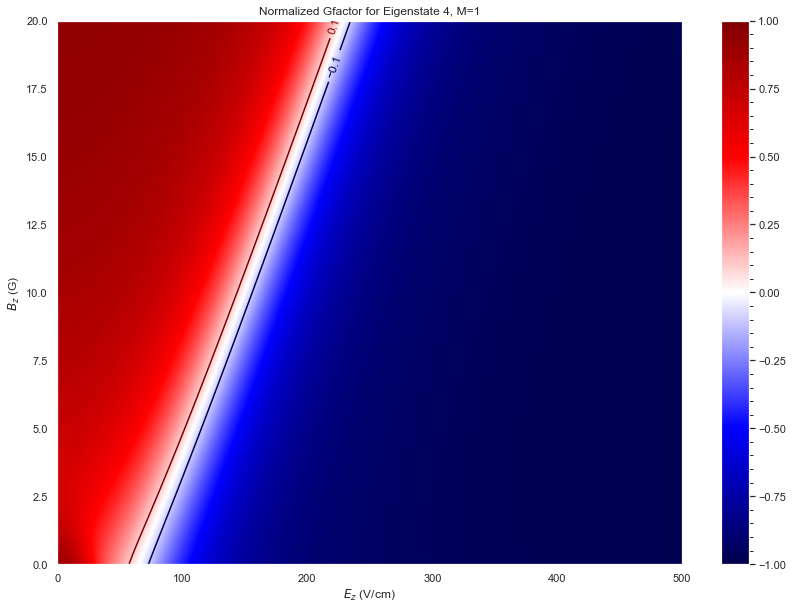

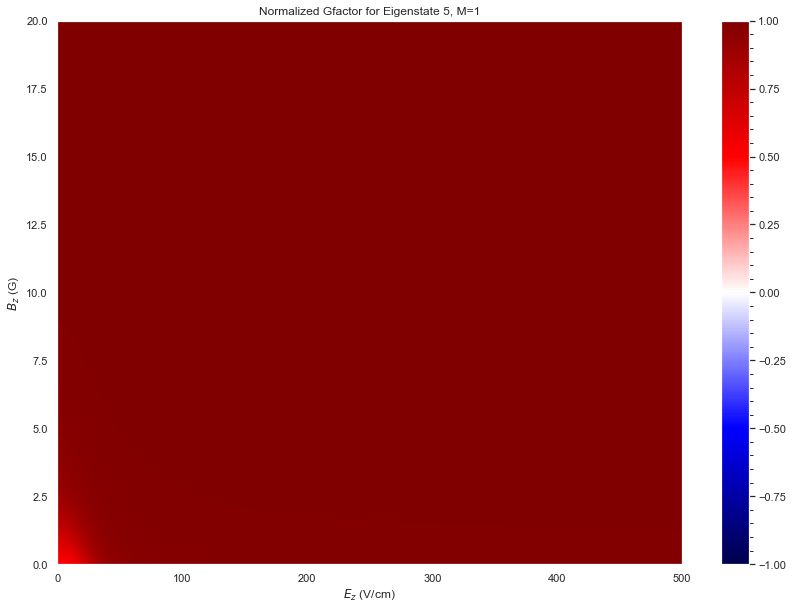

In [220]:
muBgS=1.399624494*2.0023/2
with_contour = True
for M in eval_dict.keys():
    if abs(M)==2:
        continue
    print(M)
    evals_EB = eval_dict[M]
    for i in range(len(evals_EB)):
        plt.figure(figsize=(14,10))
        geff = np.gradient(evals_EB[i])[1]/(Bz[1]-Bz[0])
        plt.grid(False)
        plt.pcolormesh(*mesh,geff/muBgS,shading='auto',cmap='seismic',vmin=-1,vmax=1)
        cbar = plt.colorbar()
        cbar.minorticks_on()
        if with_contour:
            try:
                conmap = plt.contour(*mesh,geff/muBgS,cmap='seismic',levels=[-0.1,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
                plt.clabel(conmap, inline=True, fontsize=12)
    #             cbar = plt.colorbar()
    #             cbar.minorticks_on()
            except ValueError:
                print("Can't plot this data")
        plt.title('normalized Gfactor for Eigenstate {}, M={}'.format(i,M))
        plt.xlabel(r'$E_z$ (V/cm)')
        plt.ylabel(r'$B_z$ (G)')

-2


C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_17868/1501560899.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


-1
0
1


C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_17868/1501560899.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


2


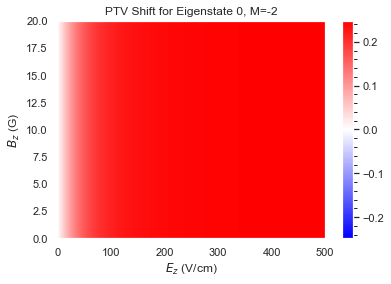

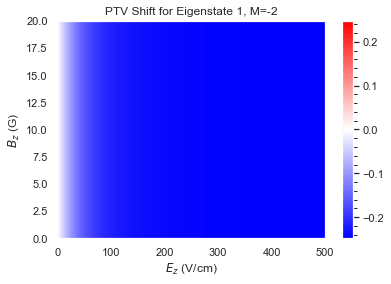

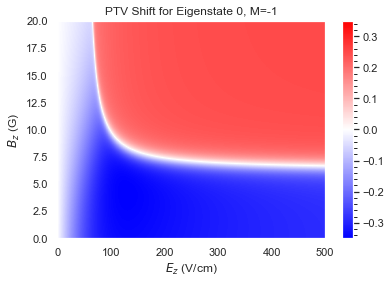

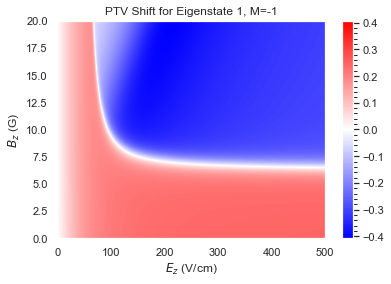

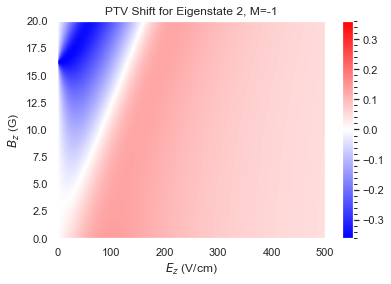

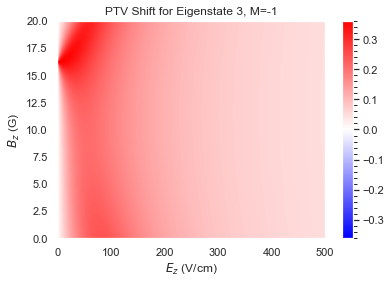

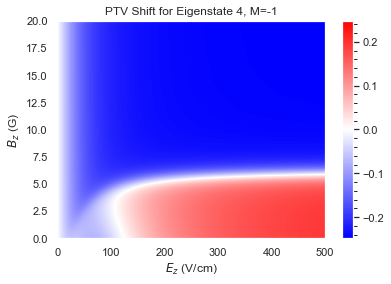

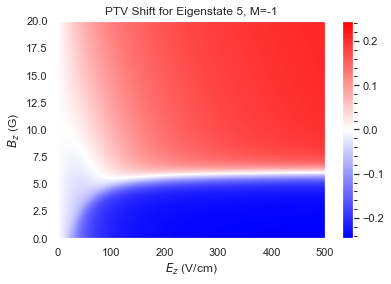

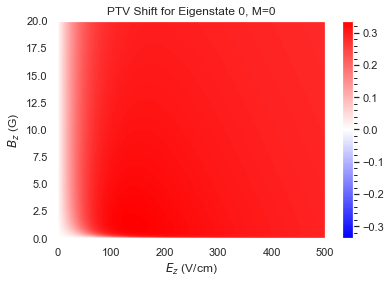

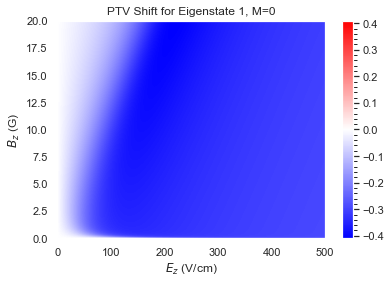

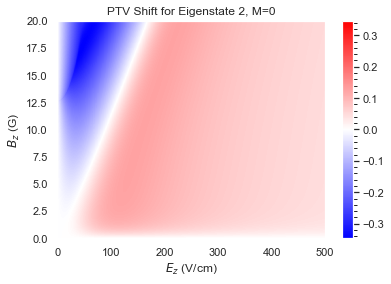

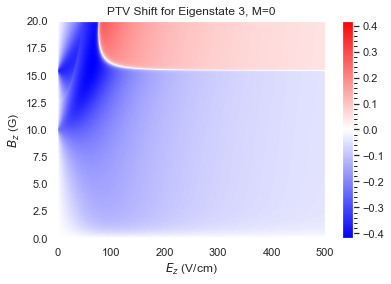

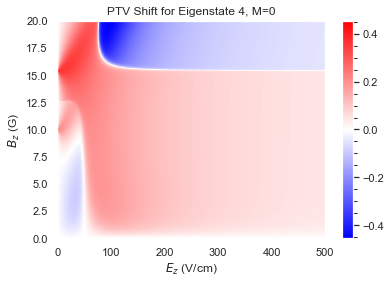

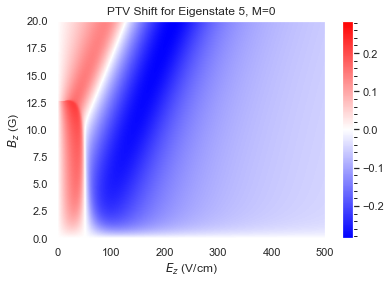

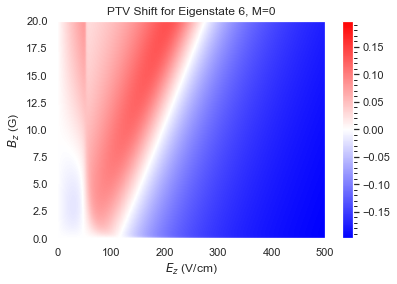

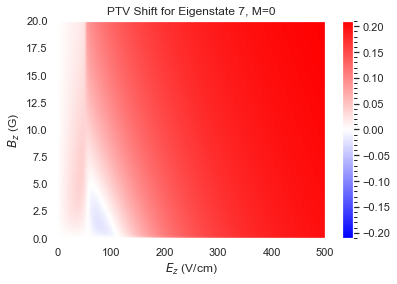

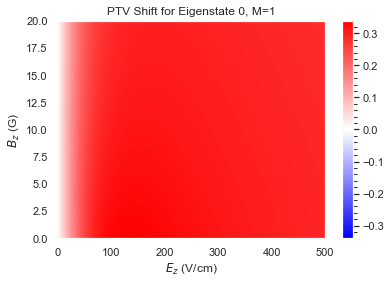

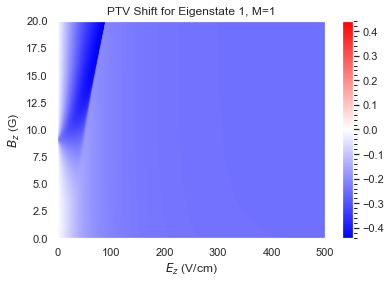

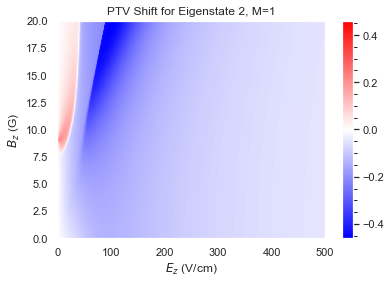

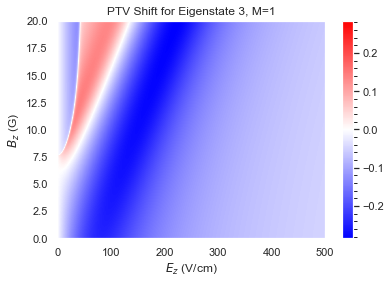

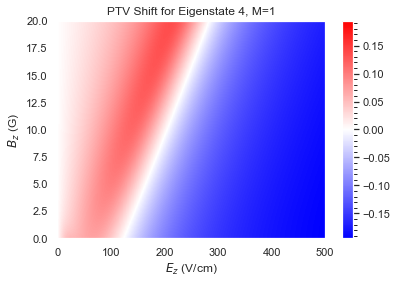

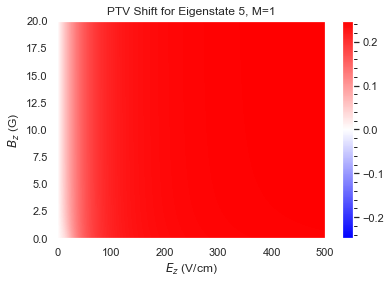

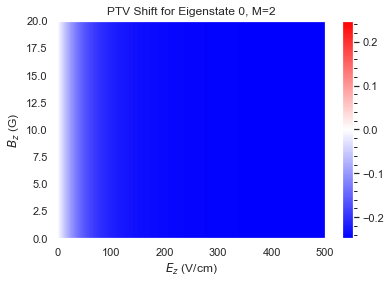

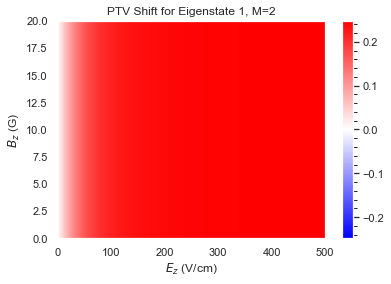

In [94]:
for M in eval_dict.keys():
    print(M)
    PTV_EB = PTV_dict[M]
    for i in range(len(PTV_EB)):
        plt.figure()
        PTV = PTV_EB[i]
        max_delta = max(abs(PTV.max()),abs(PTV.min()))
        plt.grid(False)
        plt.pcolormesh(*mesh,PTV,shading='auto',cmap='bwr',norm=TwoSlopeNorm(vmin=-max_delta,vcenter=0,vmax=max_delta))
        cbar = plt.colorbar()
        cbar.minorticks_on()
        plt.title('PTV Shift for Eigenstate {}, M={}'.format(i,M))
        plt.xlabel(r'$E_z$ (V/cm)')
        plt.ylabel(r'$B_z$ (G)')

In [96]:
eval_dict[0][3]-eval_dict[0][4]

array([[-15.94271, -15.94267, -15.94257, ..., -11.09706, -11.12208,
        -11.1471 ],
       [-15.94304, -15.943  , -15.9429 , ..., -11.09697, -11.12198,
        -11.147  ],
       [-15.94403, -15.944  , -15.9439 , ..., -11.09667, -11.12169,
        -11.14671],
       ...,
       [-40.21951, -40.21936, -40.21894, ..., -12.61294, -12.64068,
        -12.66841],
       [-40.21984, -40.2197 , -40.21928, ..., -12.61309, -12.64083,
        -12.66857],
       [-40.22018, -40.22004, -40.21962, ..., -12.61325, -12.64098,
        -12.66872]])

In [164]:
d = eval_dict[0][3]-eval_dict[0][4]
(abs(d)<0.1).any()

True

In [141]:
x = np.zeros((100,100))
y = np.zeros((100,100))+1
y[3:5,20:80] = 1

In [142]:
d = x-y
testmesh = np.array(np.meshgrid(np.arange(100),np.arange(100),indexing='ij'))

C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_17868/1015796236.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


Text(0, 0.5, '$B_z$ (G)')

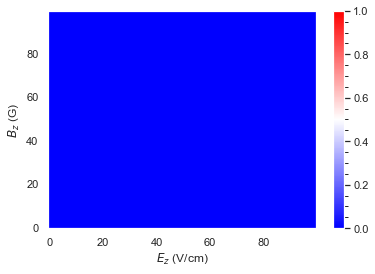

In [143]:
plt.figure()
plt.grid(False)
plt.pcolormesh(*testmesh,abs(d)<0.1,shading='auto',cmap='bwr',vmin=0,vmax=1)
cbar = plt.colorbar()
cbar.minorticks_on()
plt.xlabel(r'$E_z$ (V/cm)')
plt.ylabel(r'$B_z$ (G)')

In [154]:
(abs(d)<0.1).nonzero()[0].size

0

In [158]:
len(eval_dict.keys())

5

In [170]:
E_thresh = 0.1
PTV_thresh = 0.1
geff_thresh = 0.01
Ez_idx_match = []
Bz_idx_match = []
eigenstate_match = []
M_match = []
M_list = list(eval_dict.keys())
for Midx in range(len(M_list)):
    Mi = M_list[Midx]
    for Mjdx in range(Midx,len(M_list)):
        Mj = M_list[Mjdx]
        if abs(Mi-Mj)>2:
            continue
        else:
            evals_Mi = eval_dict[Mi]
            evals_Mj = eval_dict[Mj]
            PTV_Mi = PTV_dict[Mi]
            PTV_Mj = PTV_dict[Mj]
            for i in range(len(evals_Mi)):
                for j in range(i,len(evals_Mj)):
                    if i==j and Mi==Mj:
                        continue
                    deltaE_ij = evals_Mi[i]-evals_Mj[j]
                    E_bool_match = (abs(deltaE_ij)<E_thresh)
                    if E_bool_match.any():
                        geff_i = np.gradient(evals_Mi[i])[1]/(Bz[1]-Bz[0])
                        geff_j = np.gradient(evals_Mj[j])[1]/(Bz[1]-Bz[0])
                        deltag_ij = geff_i - geff_j
                        g_bool_match = np.logical_and(abs(deltag_ij)<geff_thresh, E_bool_match)
                        if g_bool_match.any():
                            PTV_i = PTV_Mi[i]
                            PTV_j = PTV_Mj[j]
                            deltaPTV_ij = PTV_i - PTV_j
                            PTV_bool_match = np.logical_and(abs(deltaPTV_ij)>PTV_thresh, g_bool_match)
                            if PTV_bool_match.any():
                                #Found a match!
                                idx_match = PTV_bool_match.nonzero()
                                print('Found a match!')
                                print('i = {}, Mi = {}'.format(i,Mi))
                                print('j = {}, Mj = {}'.format(j,Mj))
                                print('Ez vals = {}'.format(Ez[idx_match[0]]))
                                print('Bz vals = {}'.format(Bz[idx_match[1]]))
                                print('delta geff = {}'.format(deltag_ij[idx_match]))
                                print('delta PTV = {}'.format(deltaPTV_ij[idx_match]))
                                Ez_idx_match.append(idx_match[0])
                                Bz_idx_match.append(idx_match[1])
                                eigenstate_match.append([i,j])
                                M_match.append([Mi,Mj])

Found a match!
i = 3, Mi = -1
j = 4, Mj = 0
Ez vals = [78.53927 78.53927 78.53927 78.53927 78.53927 78.53927 78.53927 78.53927
 78.78939 78.78939 78.78939 78.78939 78.78939 78.78939 78.78939 79.03952
 79.03952 79.03952 79.03952 79.03952 79.03952 79.03952 79.28964 79.28964
 79.28964 79.28964 79.28964 79.28964 79.28964 79.28964]
Bz vals = [19.52976 19.53977 19.54977 19.55978 19.56978 19.57979 19.58979 19.5998
 19.54977 19.55978 19.56978 19.57979 19.58979 19.5998  19.6098  19.56978
 19.57979 19.58979 19.5998  19.6098  19.61981 19.62981 19.58979 19.5998
 19.6098  19.61981 19.62981 19.63982 19.64982 19.65983]
delta geff = [-0.0076  -0.0052  -0.0028  -0.0004   0.00198  0.00436  0.00673  0.00909
 -0.00748 -0.00496 -0.00244  0.00008  0.00259  0.00509  0.00759 -0.00808
 -0.00546 -0.00283 -0.00022  0.0024   0.005    0.00761 -0.00927 -0.00656
 -0.00386 -0.00116  0.00154  0.00424  0.00693  0.00962]
delta PTV = [0.55281 0.55244 0.55204 0.55164 0.55121 0.55077 0.55031 0.54983 0.57322
 0.57294 0.5726

Found a match!
i = 3, Mi = -1
j = 3, Mj = 1
Ez vals = [59.77989 59.77989 59.77989 ... 61.03052 61.03052 61.03052]
Bz vals = [2.88144 2.89145 2.90145 ... 1.32066 1.33067 1.34067]
delta geff = [ 0.00984  0.00968  0.00952 ... -0.00986 -0.00991 -0.00997]
delta PTV = [0.42861 0.42846 0.42831 ... 0.45021 0.45013 0.45006]
Found a match!
i = 4, Mi = -1
j = 4, Mj = 1
Ez vals = [65.03252 65.03252 65.03252 65.03252 65.03252 65.03252 65.03252 65.03252
 65.03252 65.03252 65.03252 65.03252 65.03252 65.03252 65.03252 65.03252
 65.03252 65.03252 65.03252 65.03252 65.03252 65.03252 65.03252 65.03252
 65.03252 65.03252 65.03252 65.03252 65.03252 65.03252 65.28264 65.28264
 65.28264 65.28264 65.28264 65.28264 65.28264 65.28264 65.28264 65.28264
 65.28264 65.28264 65.28264 65.28264 65.28264 65.28264 65.28264 65.28264
 65.28264 65.28264 65.28264 65.28264 65.28264 65.28264 65.28264 65.28264
 65.28264 65.28264 65.28264 65.28264 65.28264 65.28264 65.28264 65.28264
 65.28264 65.28264 65.28264 65.28264 65.28264

Found a match!
i = 1, Mi = 1
j = 2, Mj = 1
Ez vals = [0.25013]
Bz vals = [9.06453]
delta geff = [0.009]
delta PTV = [-0.43555]


In [172]:
Ez_idx_match[-2]

array([260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260,
       260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260,
       260, 260, 260, 260, 261, 261, 261, 261, 261, 261, 261, 261, 261,
       261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
       261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
       261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
       261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
       261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 262, 262, 262,
       262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262,
       262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262,
       262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262,
       262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262,
       262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262,
       262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 26

C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_17868/3096316483.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()
C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_17868/3096316483.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


Text(0, 0.5, '$B_z$ (G)')

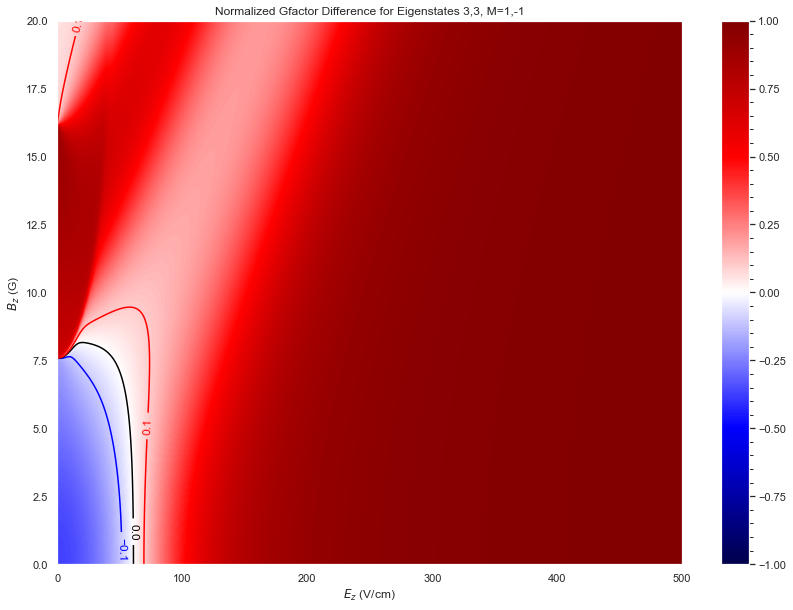

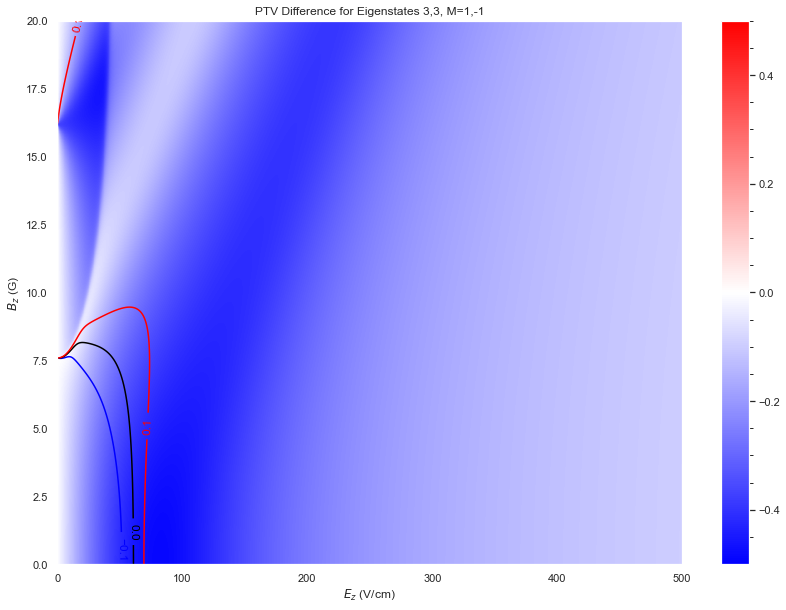

In [373]:
muBgS=1.399624494*2.0023/2
with_contour = True
idx = 3
evals_1 = eval_dict[1][idx]
evals_2 = eval_dict[-1][idx]
plt.figure(figsize=(14,10))
geff_1 = np.gradient(evals_1)[1]/(Bz[1]-Bz[0])
geff_2 = np.gradient(evals_2)[1]/(Bz[1]-Bz[0])
delta_geff = geff_1 - geff_2
plt.grid(False)
plt.pcolormesh(*mesh,delta_geff/(2*muBgS),shading='auto',cmap='seismic',vmin=-1,vmax=1)
cbar = plt.colorbar()
cbar.minorticks_on()
if with_contour:
    try:
        conmap = plt.contour(*mesh,delta                                          _geff/(2*muBgS),colors=['blue','black','red'],levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap, inline=True, fontsize=12)
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('normalized Gfactor Difference for Eigenstates {},{}, M=1,-1'.format(idx,idx))
plt.xlabel(r'$E_z$ (V/cm)')
plt.ylabel(r'$B_z$ (G)')

PTV_1 = PTV_dict[1][idx]
PTV_2 = PTV_dict[-1][idx]
plt.figure(figsize=(14,10))
delta_PTV = PTV_1 - PTV_2
plt.grid(False)
plt.pcolormesh(*mesh,delta_PTV,shading='auto',cmap='bwr',vmin=-0.5,vmax=0.5)
cbar = plt.colorbar()
cbar.minorticks_on()
if with_contour:
    try:
        conmap = plt.contour(*mesh,delta_geff/(2*muBgS),colors=['blue','black','red'],levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap, inline=True, fontsize=12)
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('PTV Difference for Eigenstates {},{}, M=1,-1'.format(idx,idx))
plt.xlabel(r'$E_z$ (V/cm)')
plt.ylabel(r'$B_z$ (G)')

C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_17868/1155249723.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()
C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_17868/1155249723.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


Text(0, 0.5, '$B_z$ (G)')

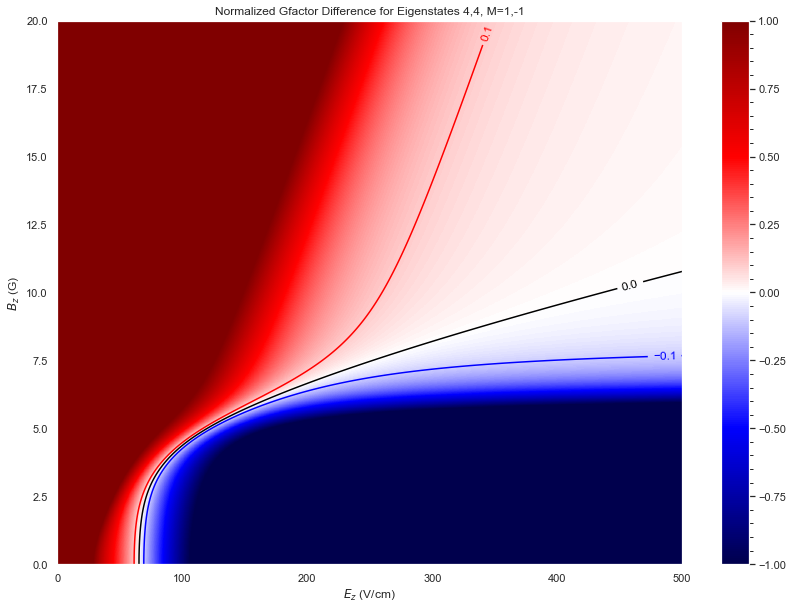

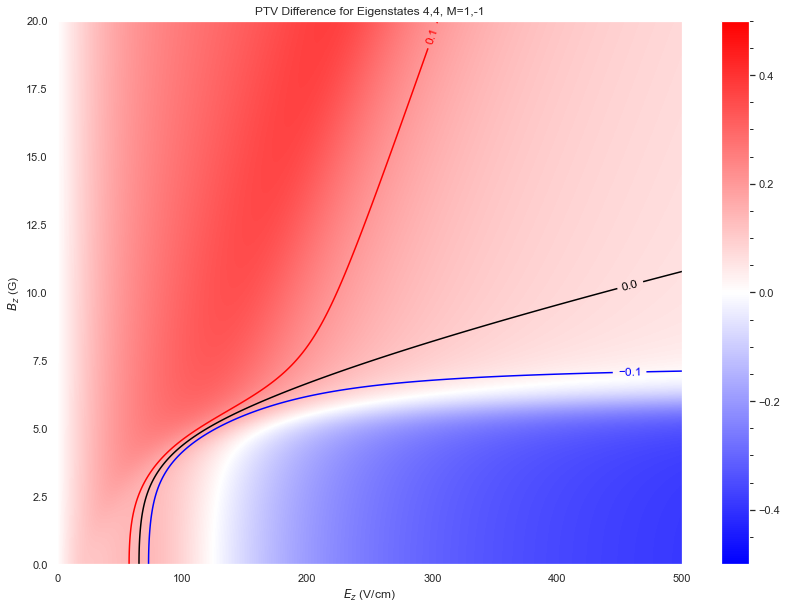

In [372]:
muBgS=1.399624494*2.0023/2
with_contour = True
idx = 4
evals_1 = eval_dict[1][idx]
evals_2 = eval_dict[-1][idx]
plt.figure(figsize=(14,10))
geff_1 = np.gradient(evals_1)[1]/(Bz[1]-Bz[0])
geff_2 = np.gradient(evals_2)[1]/(Bz[1]-Bz[0])
delta_geff = geff_1 - geff_2
plt.grid(False)
plt.pcolormesh(*mesh,delta_geff/muBgS,shading='auto',cmap='seismic',vmin=-1,vmax=1)
cbar = plt.colorbar()
cbar.minorticks_on()
if with_contour:
    try:
        conmap = plt.contour(*mesh,delta_geff/muBgS,colors=['blue','black','red'],levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap, inline=True, fontsize=12)
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('normalized Gfactor Difference for Eigenstates {},{}, M=1,-1'.format(idx,idx))
plt.xlabel(r'$E_z$ (V/cm)')
plt.ylabel(r'$B_z$ (G)')

PTV_1 = PTV_dict[1][idx]
PTV_2 = PTV_dict[-1][idx]
plt.figure(figsize=(14,10))
delta_PTV = PTV_1 - PTV_2
plt.grid(False)
plt.pcolormesh(*mesh,delta_PTV,shading='auto',cmap='bwr',vmin=-0.5,vmax=0.5)
cbar = plt.colorbar()
cbar.minorticks_on()
if with_contour:
    try:
        conmap = plt.contour(*mesh,delta_geff/(2*muBgS),colors=['blue','black','red'],levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap, inline=True, fontsize=12)
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('PTV Difference for Eigenstates {},{}, M=1,-1'.format(idx,idx))
plt.xlabel(r'$E_z$ (V/cm)')
plt.ylabel(r'$B_z$ (G)')

In [270]:
Em = np.searchsorted(Ez,40)
Em

160

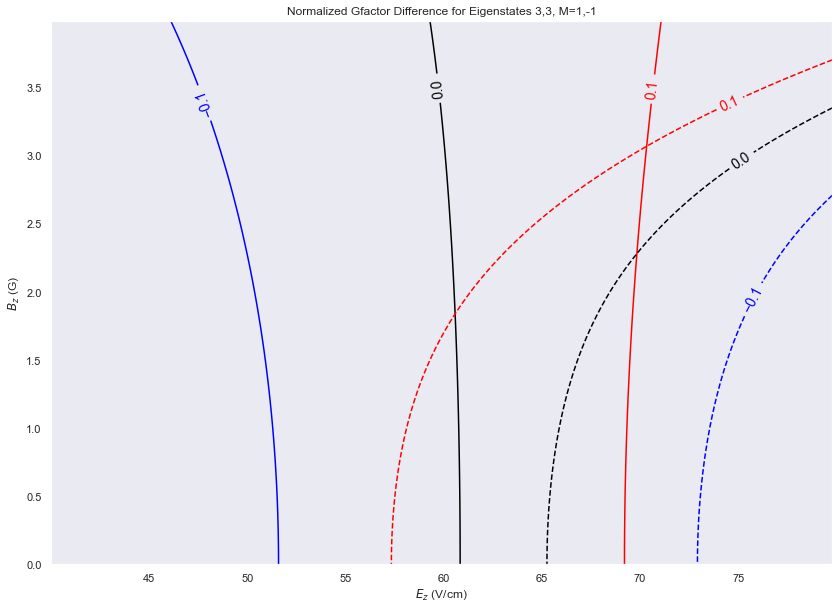

In [72]:
El = np.searchsorted(Ez,40)
Eu = np.searchsorted(Ez,80)
Bl = np.searchsorted(Bz,0)
Bu = np.searchsorted(Bz,4)
s1 = slice(El,Eu)
s2 = slice(Bl,Bu)


muBgS=1.399624494*2.0023/2
with_contour = True
idx = 3
evals_1 = eval_dict[1][idx]
evals_2 = eval_dict[-1][idx]
plt.figure(figsize=(14,10))
geff_1 = np.gradient(evals_1)[1]/(Bz[1]-Bz[0])
geff_2 = np.gradient(evals_2)[1]/(Bz[1]-Bz[0])
delta_geff = geff_1 - geff_2
plt.grid(False)
# plt.pcolormesh(*mesh,delta_geff/muBgS,shading='auto',cmap='seismic',vmin=-1,vmax=1)
# cbar = plt.colorbar()
# cbar.minorticks_on()
if with_contour:
    try:
        conmap1 = plt.contour(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS/2,colors=['blue','black','red'],levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap1, inline=True,inline_spacing=5, fontsize=14,rightside_up=False,manual=[(50,3.5),(60,3.5),(70,3.5)])
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('normalized Gfactor Difference for Eigenstates {},{}, M=1,-1'.format(idx,idx))
plt.xlabel(r'$E_z$ (V/cm)')
plt.ylabel(r'$B_z$ (G)')

idx = 4
evals_1 = eval_dict[1][idx]
evals_2 = eval_dict[-1][idx]
geff_1 = np.gradient(evals_1)[1]/(Bz[1]-Bz[0])
geff_2 = np.gradient(evals_2)[1]/(Bz[1]-Bz[0])
delta_geff = geff_1 - geff_2
plt.grid(False)
# plt.pcolormesh(*mesh,delta_geff/muBgS,shading='auto',cmap='seismic',vmin=-1,vmax=1)
# cbar = plt.colorbar()
# cbar.minorticks_on()
if with_contour:
    try:
        conmap2 = plt.contour(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS/2,colors=['blue','black','red'],linestyles='dashed',levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap2,inline=True,inline_spacing=5,fontsize=14,rightside_up=True,manual=[(75,3.25),(75,3),(75,2)])
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")

In [392]:
np.linspace(-0.1,0.1,21)

array([-0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,
        0.08,  0.09,  0.1 ])

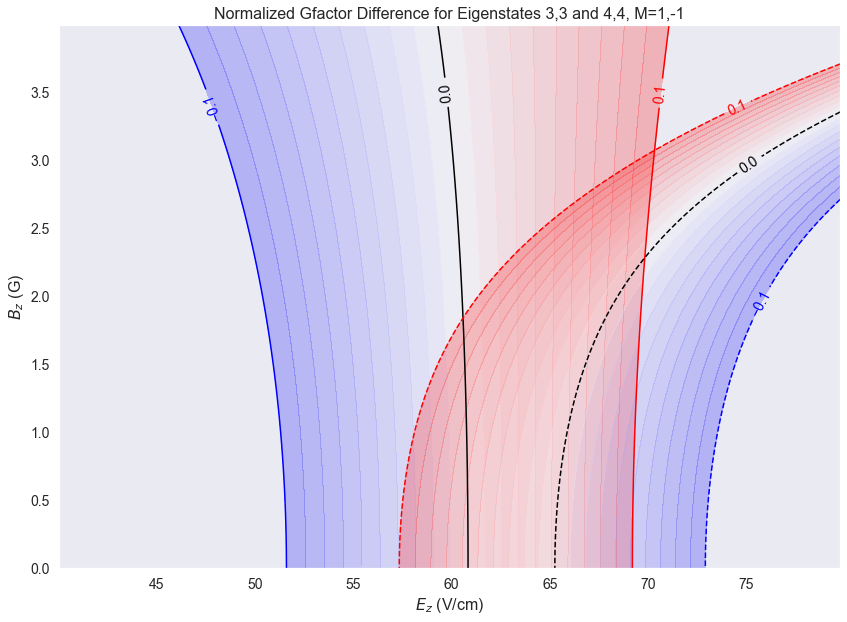

In [68]:
El = np.searchsorted(Ez,40)
Eu = np.searchsorted(Ez,80)
Bl = np.searchsorted(Bz,0)
Bu = np.searchsorted(Bz,4)
s1 = slice(El,Eu)
s2 = slice(Bl,Bu)


muBgS=1.399624494*2.0023/2
with_contour = True
idx = 3
evals_1 = eval_dict[1][idx]
evals_2 = eval_dict[-1][idx]
plt.figure(figsize=(14,10))
geff_1 = np.gradient(evals_1)[1]/(Bz[1]-Bz[0])
geff_2 = np.gradient(evals_2)[1]/(Bz[1]-Bz[0])
delta_geff = geff_1 - geff_2
plt.grid(False)
# PTV_1 = PTV_dict[1][idx]
# PTV_2 = PTV_dict[-1][idx]
# delta_PTV = PTV_1 - PTV_2
# plt.contourf(*mesh[:,s1,s2],delta_PTV[s1,s2],levels=10,cmap='cool')
# cbar = plt.colorbar()
# cbar.minorticks_on()
if with_contour:
    try:
        conmap1 = plt.contour(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS/2,colors=['blue','black','red'],levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap1, inline=True,inline_spacing=5,manual=[(50,3.5),(60,3.5),(70,3.5)], fontsize=14,rightside_up=False)
        smallmap1 = plt.contourf(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS/2,cmap='bwr',levels=np.linspace(-0.1,0.1,21),alpha=0.25,vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('normalized Gfactor Difference for Eigenstates 3,3 and 4,4, M=1,-1'.format(idx,idx),size=16)
plt.xlabel(r'$E_z$ (V/cm)',size=16)
plt.ylabel(r'$B_z$ (G)',size=16)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

idx = 4
evals_1 = eval_dict[1][idx]
evals_2 = eval_dict[-1][idx]
geff_1 = np.gradient(evals_1)[1]/(Bz[1]-Bz[0])
geff_2 = np.gradient(evals_2)[1]/(Bz[1]-Bz[0])
delta_geff = geff_1 - geff_2
plt.grid(False)
# plt.pcolormesh(*mesh,delta_geff/muBgS,shading='auto',cmap='seismic',vmin=-1,vmax=1)
# cbar = plt.colorbar()
# cbar.minorticks_on()
if with_contour:
    try:
        conmap2 = plt.contour(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS/2,colors=['blue','black','red'],linestyles='dashed',levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap2,inline=True,inline_spacing=5, manual=[(75,3.25),(75,3),(75,2)],fontsize=14,rightside_up=True)
        smallmap2 = plt.contourf(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS/2,cmap='bwr',linestyles='dashed',levels=np.linspace(-0.1,0.1,21),alpha=0.25,vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")

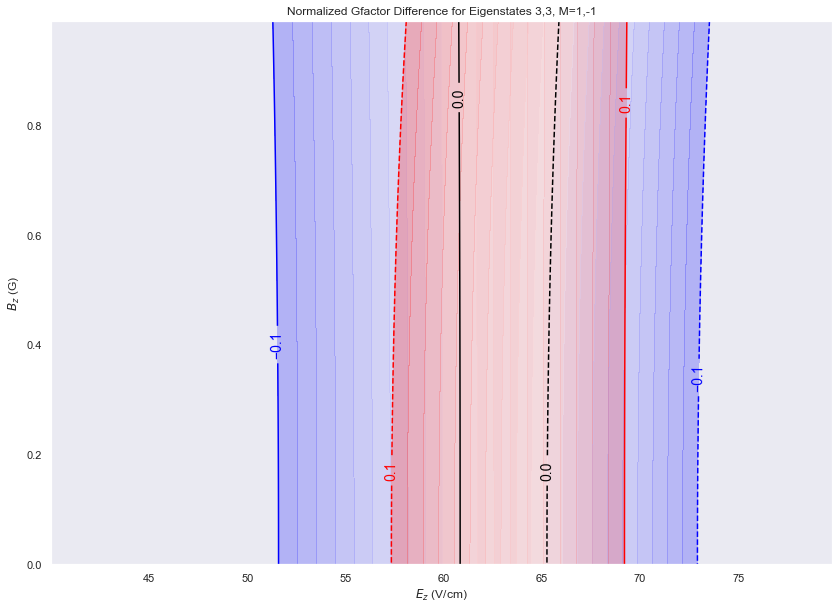

In [394]:
El = np.searchsorted(Ez,40)
Eu = np.searchsorted(Ez,80)
Bl = np.searchsorted(Bz,0)
Bu = np.searchsorted(Bz,1)
s1 = slice(El,Eu)
s2 = slice(Bl,Bu)


muBgS=1.399624494*2.0023/2
with_contour = True
idx = 3
evals_1 = eval_dict[1][idx]
evals_2 = eval_dict[-1][idx]
plt.figure(figsize=(14,10))
geff_1 = np.gradient(evals_1)[1]/(Bz[1]-Bz[0])
geff_2 = np.gradient(evals_2)[1]/(Bz[1]-Bz[0])
delta_geff = geff_1 - geff_2
plt.grid(False)
# PTV_1 = PTV_dict[1][idx]
# PTV_2 = PTV_dict[-1][idx]
# delta_PTV = PTV_1 - PTV_2
# plt.contourf(*mesh[:,s1,s2],delta_PTV[s1,s2],levels=10,cmap='cool')
# cbar = plt.colorbar()
# cbar.minorticks_on()
if with_contour:
    try:
        conmap1 = plt.contour(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS/2,colors=['blue','black','red'],levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap1, inline=True,inline_spacing=5, fontsize=14,rightside_up=False)
        smallmap1 = plt.contourf(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS/2,cmap='bwr',levels=np.linspace(-0.1,0.1,21),alpha=0.25,vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('normalized Gfactor Difference for Eigenstates {},{}, M=1,-1'.format(idx,idx))
plt.xlabel(r'$E_z$ (V/cm)')
plt.ylabel(r'$B_z$ (G)')

idx = 4
evals_1 = eval_dict[1][idx]
evals_2 = eval_dict[-1][idx]
geff_1 = np.gradient(evals_1)[1]/(Bz[1]-Bz[0])
geff_2 = np.gradient(evals_2)[1]/(Bz[1]-Bz[0])
delta_geff = geff_1 - geff_2
plt.grid(False)
# plt.pcolormesh(*mesh,delta_geff/muBgS,shading='auto',cmap='seismic',vmin=-1,vmax=1)
# cbar = plt.colorbar()
# cbar.minorticks_on()
if with_contour:
    try:
        conmap2 = plt.contour(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS/2,colors=['blue','black','red'],linestyles='dashed',levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap2,inline=True,inline_spacing=5,fontsize=14,rightside_up=True)
        smallmap2 = plt.contourf(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS/2,cmap='bwr',linestyles='dashed',levels=np.linspace(-0.1,0.1,21),alpha=0.25,vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")

C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_17868/3213161298.py:42: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


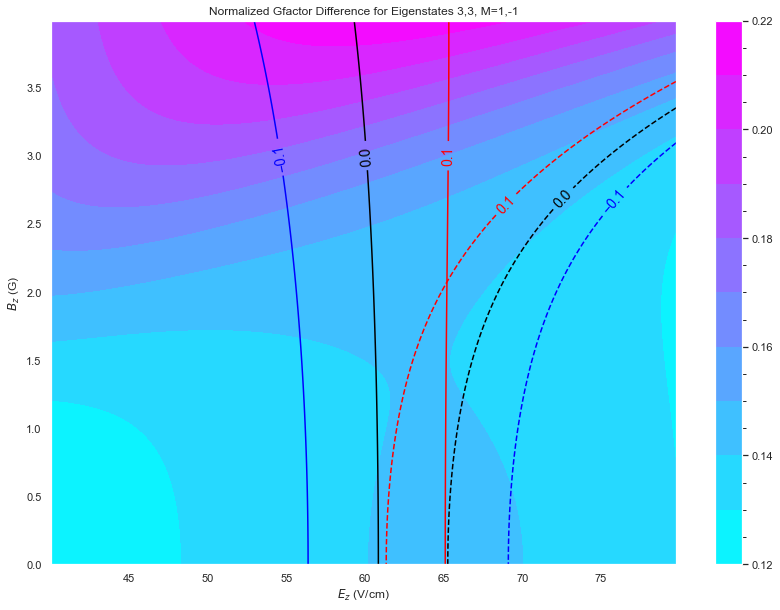

In [305]:
El = np.searchsorted(Ez,40)
Eu = np.searchsorted(Ez,80)
Bl = np.searchsorted(Bz,0)
Bu = np.searchsorted(Bz,4)
s1 = slice(El,Eu)
s2 = slice(Bl,Bu)


muBgS=1.399624494*2.0023/2
with_contour = True
idx = 3
evals_1 = eval_dict[1][idx]
evals_2 = eval_dict[-1][idx]
plt.figure(figsize=(14,10))
geff_1 = np.gradient(evals_1)[1]/(Bz[1]-Bz[0])
geff_2 = np.gradient(evals_2)[1]/(Bz[1]-Bz[0])
delta_geff = geff_1 - geff_2
plt.grid(False)
if with_contour:
    try:
        conmap1 = plt.contour(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS,colors=['blue','black','red'],levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap1, inline=True,inline_spacing=5,manual=[(55,3),(60,3),(65,3)], fontsize=14,rightside_up=False)
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")
plt.title('normalized Gfactor Difference for Eigenstates {},{}, M=1,-1'.format(idx,idx))
plt.xlabel(r'$E_z$ (V/cm)')
plt.ylabel(r'$B_z$ (G)')

idx = 4
evals_1 = eval_dict[1][idx]
evals_2 = eval_dict[-1][idx]
geff_1 = np.gradient(evals_1)[1]/(Bz[1]-Bz[0])
geff_2 = np.gradient(evals_2)[1]/(Bz[1]-Bz[0])
delta_geff = geff_1 - geff_2
plt.grid(False)
PTV_1 = PTV_dict[1][idx]
PTV_2 = PTV_dict[-1][idx]
delta_PTV = PTV_1 - PTV_2
plt.contourf(*mesh[:,s1,s2],delta_PTV[s1,s2],levels=10,cmap='cool')
cbar = plt.colorbar()
cbar.minorticks_on()
# plt.pcolormesh(*mesh,delta_geff/muBgS,shading='auto',cmap='seismic',vmin=-1,vmax=1)
# cbar = plt.colorbar()
# cbar.minorticks_on()
if with_contour:
    try:
        conmap2 = plt.contour(*mesh[:,s1,s2],delta_geff[s1,s2]/muBgS,colors=['blue','black','red'],linestyles='dashed',levels=[-0.1,0,0.1],vmin=-0.1,vmax=0.1)#norm=TwoSlopeNorm(vmin=-1,vcenter=0,vmax=1))
        plt.clabel(conmap2,inline=True,inline_spacing=5, manual=[(68,2.75),(72,2.75),(75,2.75)],fontsize=14,rightside_up=True)
#             cbar = plt.colorbar()
#             cbar.minorticks_on()
    except ValueError:
        print("Can't plot this data")